In [6]:
"""
==========================
EEG Data Quality Checker
==========================
This script checks whether EEG data segments (in .fif or .npy format)
are clean, usable, or noisy before feature extraction.

It performs:
  1️⃣ Basic statistical checks (mean, RMS)
  2️⃣ Power Spectral Density (PSD) analysis
  3️⃣ Channel correlation analysis
  4️⃣ Amplitude distribution visualization
  5️⃣ Automatic noise flagging

Author: <Mayuk Sarkar>
"""

import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import glob
from pathlib import Path

# ---- Configuration ----
DATA_PATH = "Segments"          # Folder with .fif or .npy files
SFREQ = 250                     # Sampling frequency (Hz), only used if .npy files
THRESHOLD_RMS = 200e-6          # 200 µV RMS threshold for noise flagging






In [8]:

# ---------------------------------------------------------------------------
#   Function: Load file (works for both .fif and .npy)
# ---------------------------------------------------------------------------
def load_data(file_path):
    """Load EEG data and return MNE Raw-like object and metadata."""
    if file_path.endswith(".fif"):
        raw = mne.io.read_raw_fif(file_path, preload=True, verbose='ERROR')
        data = raw.get_data()
        ch_names = raw.ch_names
        sfreq = raw.info['sfreq']
    elif file_path.endswith(".npy"):
        arr = np.load(file_path)
        if arr.ndim == 3:
            arr = arr.squeeze()
        data = arr
        ch_names = [f"Ch{i+1}" for i in range(data.shape[0])]
        sfreq = SFREQ
        info = mne.create_info(ch_names, sfreq, ch_types='eeg')
        raw = mne.io.RawArray(data, info, verbose='ERROR')
    else:
        raise ValueError("Unsupported file format. Must be .fif or .npy")
    
    return raw, data, ch_names, sfreq

In [9]:

# ---------------------------------------------------------------------------
#   Function: Quality Check
# ---------------------------------------------------------------------------
def quality_check(file_path):
    raw, data, ch_names, sfreq = load_data(file_path)

    # Step 1: Basic statistics
    means = data.mean(axis=1)
    stds = data.std(axis=1)
    rms = np.sqrt(np.mean(data**2, axis=1))

    # Step 2: Power Spectral Density (PSD)
    # Add epsilon to avoid log(0)
    f, Pxx = signal.welch(data, fs=sfreq, nperseg=min(int(sfreq * 2), data.shape[1]))
    Pxx = np.maximum(Pxx, 1e-20)
    avg_psd = np.mean(Pxx, axis=0)

    # Step 3: Channel correlation (to detect disconnected electrodes)
    corr = np.corrcoef(data)
    avg_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])

    # Step 4: Visualization
    plt.figure(figsize=(10, 4))
    plt.semilogy(f, avg_psd, color='navy')
    plt.title(f"Average PSD - {Path(file_path).name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Step 5: Amplitude distribution
    plt.figure(figsize=(6, 3))
    plt.hist(data.flatten(), bins=100, color='skyblue', edgecolor='black')
    plt.title(f"Amplitude Distribution - {Path(file_path).name}")
    plt.xlabel("Amplitude (Volts)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Step 6: Print summary stats
    print(f"\n=== File: {file_path} ===")
    print(f"Mean amplitude range: {means.min():.2e} to {means.max():.2e}")
    print(f"RMS range: {rms.min():.2e} to {rms.max():.2e}")
    print(f"Avg channel correlation: {avg_corr:.3f}")

    # Step 7: Noise / artifact flagging
    if np.any(rms > THRESHOLD_RMS):
        print("⚠️  High RMS detected — possible noisy or saturated channels.")
    if np.max(avg_psd) - np.min(avg_psd) < 10:
        print("⚠️  Flat PSD — may indicate disconnected electrodes or flat data.")
    if np.any((f > 48) & (f < 52) & (avg_psd > (avg_psd.mean() + 10))):
        print("⚠️  50 Hz spike detected — power-line interference likely.")

    # Step 8: Return metrics for summary table
    return {
        'file': Path(file_path).name,
        'mean_abs': np.mean(np.abs(means)),
        'rms_mean': np.mean(rms),
        'rms_max': np.max(rms),
        'avg_corr': avg_corr
    }




📊 Checking: Segments\ID0_EC_raw.fif


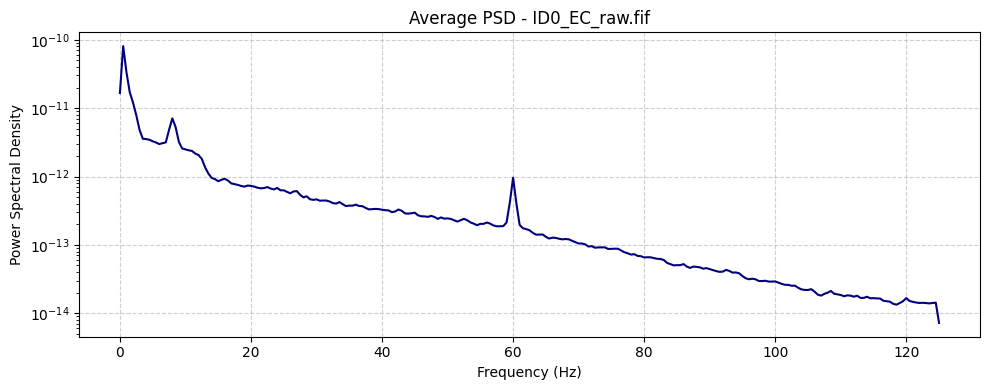

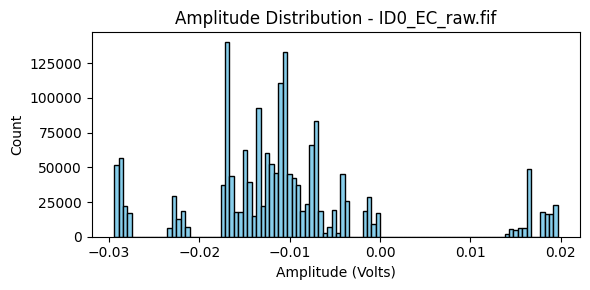


=== File: Segments\ID0_EC_raw.fif ===
Mean amplitude range: -2.91e-02 to 1.87e-02
RMS range: 1.17e-03 to 2.91e-02
Avg channel correlation: 0.686
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID0_EO_raw.fif


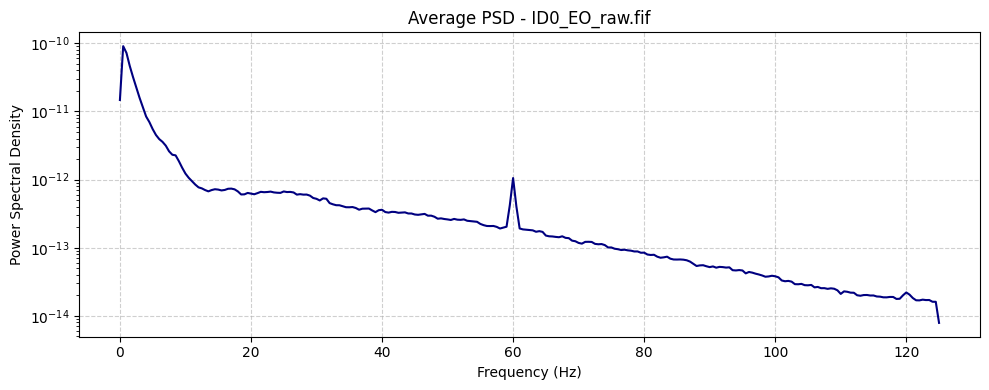

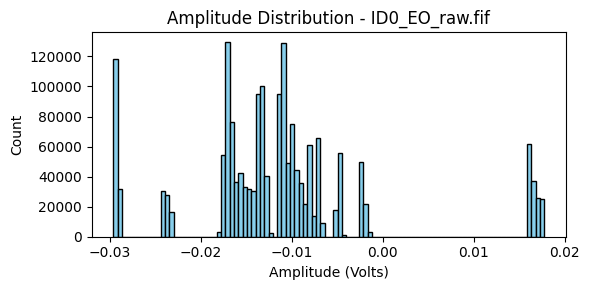


=== File: Segments\ID0_EO_raw.fif ===
Mean amplitude range: -2.94e-02 to 1.70e-02
RMS range: 2.14e-03 to 2.94e-02
Avg channel correlation: 0.209
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID10_EC_raw.fif


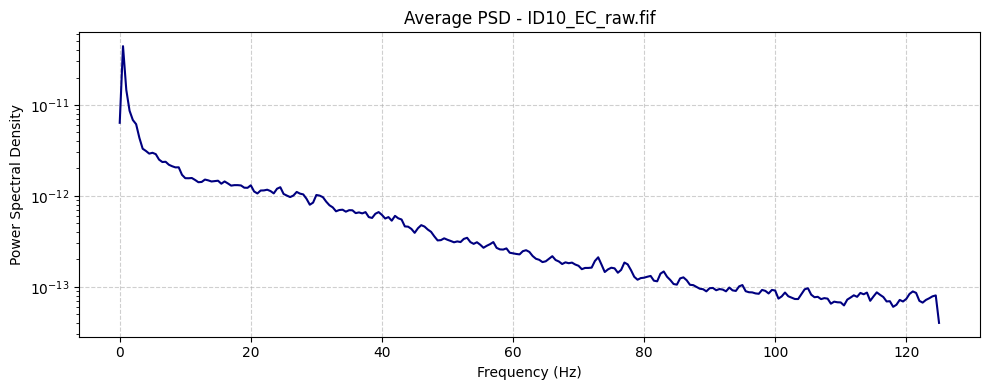


=== File: Segments\ID10_EC_raw.fif ===
Mean amplitude range: -1.74e-02 to 5.59e-04
RMS range: 5.83e-04 to 1.74e-02
Avg channel correlation: -0.014
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID10_EO_raw.fif


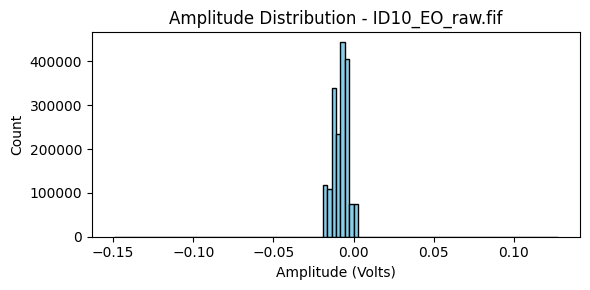


=== File: Segments\ID10_EO_raw.fif ===
Mean amplitude range: -1.68e-02 to 3.31e-04
RMS range: 5.60e-04 to 1.68e-02
Avg channel correlation: 0.123
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID11_EC_raw.fif



=== File: Segments\ID11_EC_raw.fif ===
Mean amplitude range: -1.01e-02 to 7.38e-03
RMS range: 1.83e-04 to 1.01e-02
Avg channel correlation: 0.078
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID11_EO_raw.fif


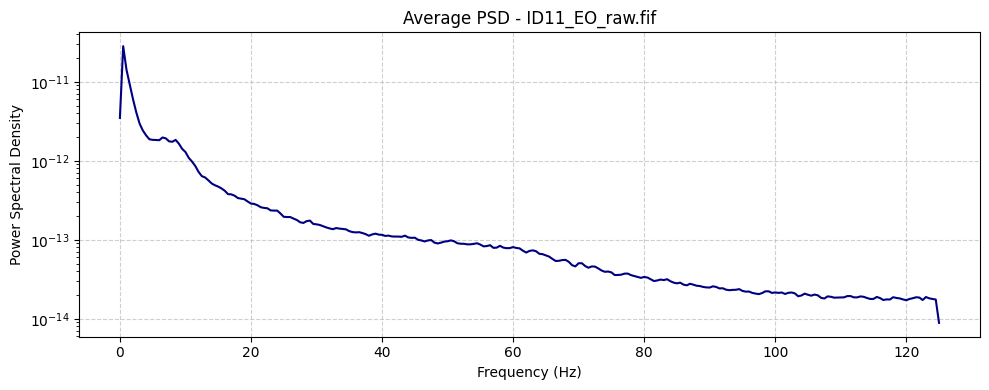

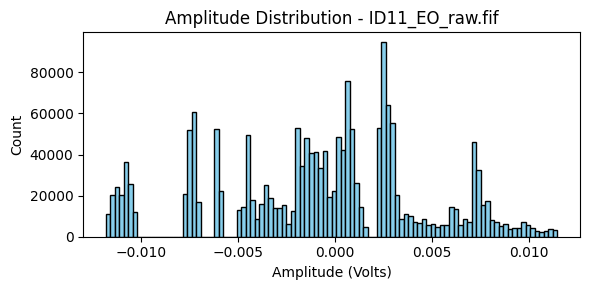


=== File: Segments\ID11_EO_raw.fif ===
Mean amplitude range: -1.11e-02 to 9.36e-03
RMS range: 6.58e-04 to 1.11e-02
Avg channel correlation: 0.375
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID13_EC_raw.fif



=== File: Segments\ID13_EC_raw.fif ===
Mean amplitude range: -1.48e-02 to 6.13e-03
RMS range: 9.12e-04 to 1.48e-02
Avg channel correlation: 0.928
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID13_EO_raw.fif


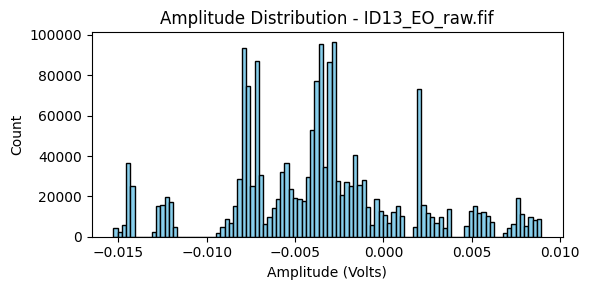


=== File: Segments\ID13_EO_raw.fif ===
Mean amplitude range: -1.44e-02 to 7.95e-03
RMS range: 6.04e-04 to 1.44e-02
Avg channel correlation: 0.273
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID14_EC_raw.fif


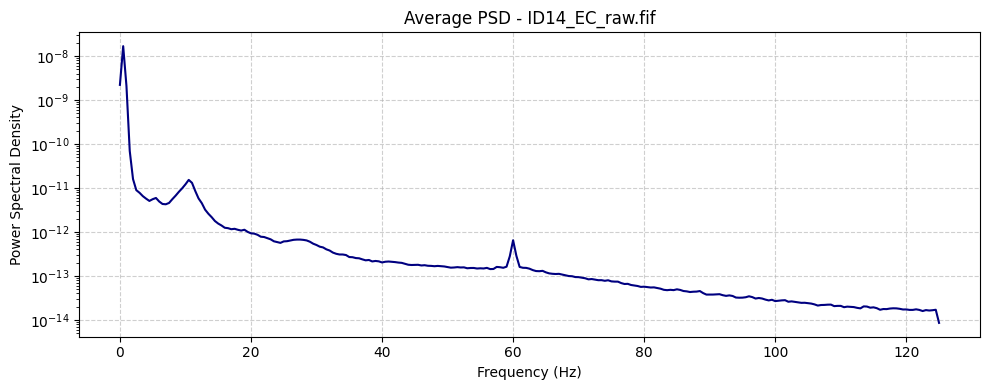

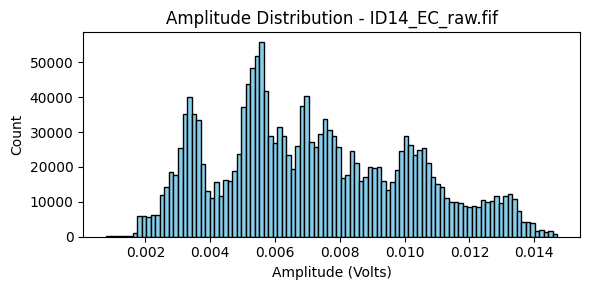


=== File: Segments\ID14_EC_raw.fif ===
Mean amplitude range: 2.88e-03 to 1.29e-02
RMS range: 2.94e-03 to 1.30e-02
Avg channel correlation: 0.598
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID14_EO_raw.fif


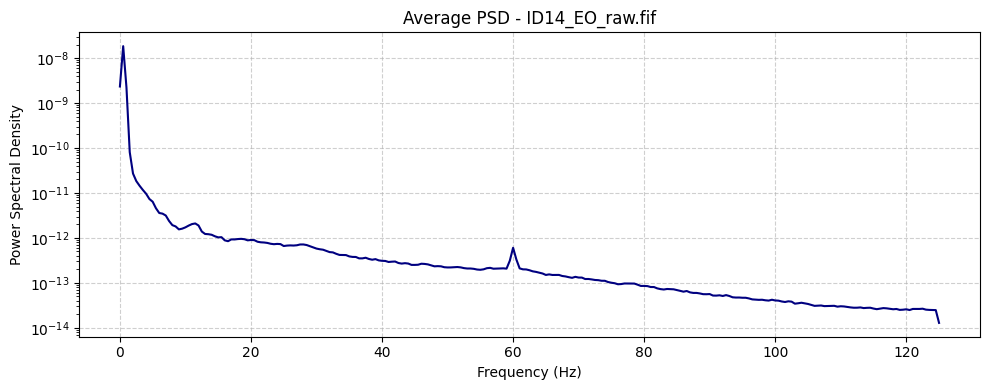

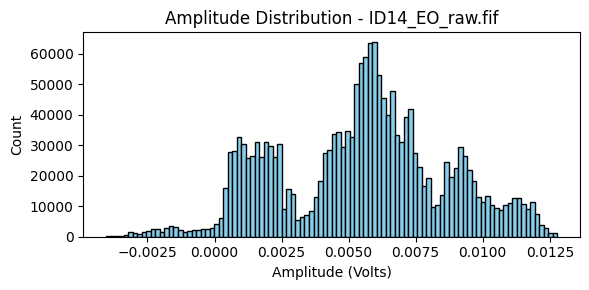


=== File: Segments\ID14_EO_raw.fif ===
Mean amplitude range: -4.98e-04 to 1.13e-02
RMS range: 1.03e-03 to 1.13e-02
Avg channel correlation: 0.613
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID15(1)_EC_raw.fif


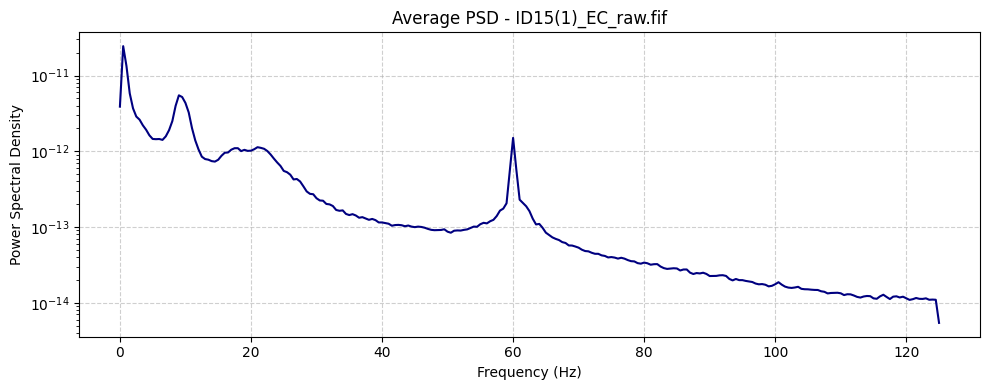

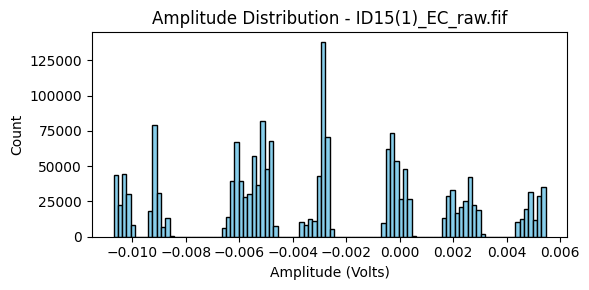


=== File: Segments\ID15(1)_EC_raw.fif ===
Mean amplitude range: -1.05e-02 to 5.27e-03
RMS range: 2.10e-04 to 1.05e-02
Avg channel correlation: -0.006
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID15(1)_EO_raw.fif


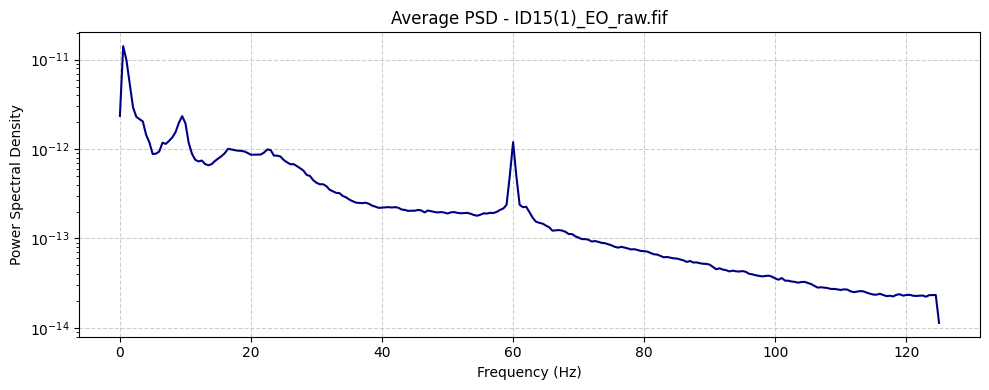

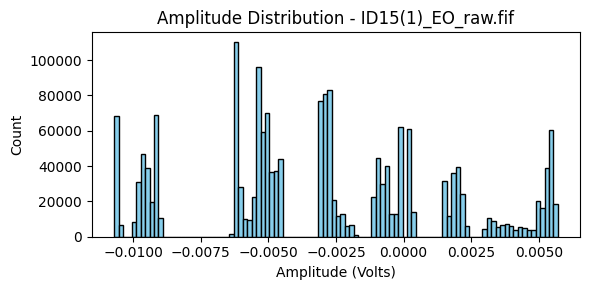


=== File: Segments\ID15(1)_EO_raw.fif ===
Mean amplitude range: -1.06e-02 to 5.45e-03
RMS range: 1.63e-04 to 1.06e-02
Avg channel correlation: 0.126
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID15_EC_raw.fif


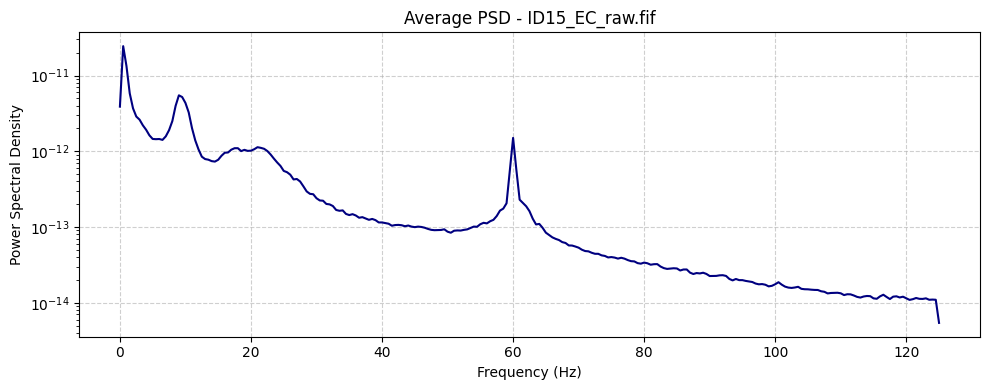

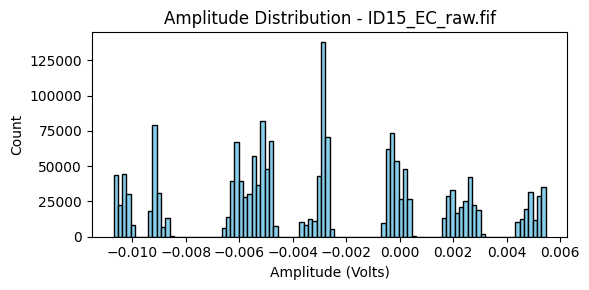


=== File: Segments\ID15_EC_raw.fif ===
Mean amplitude range: -1.05e-02 to 5.27e-03
RMS range: 2.10e-04 to 1.05e-02
Avg channel correlation: -0.006
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID15_EO_raw.fif


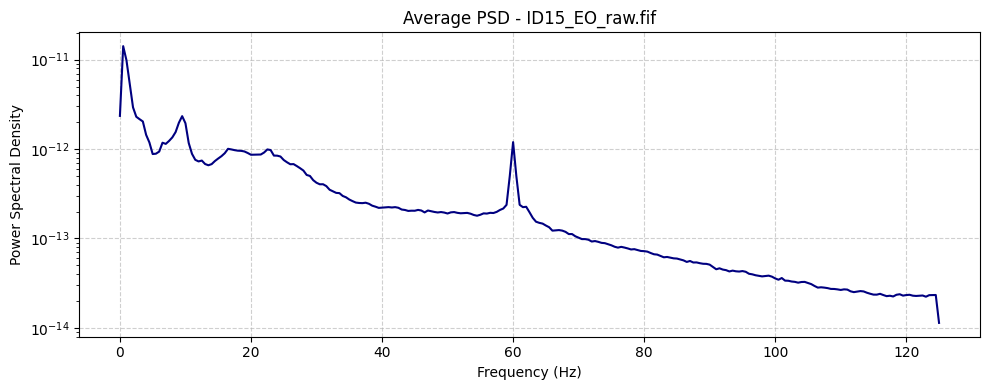

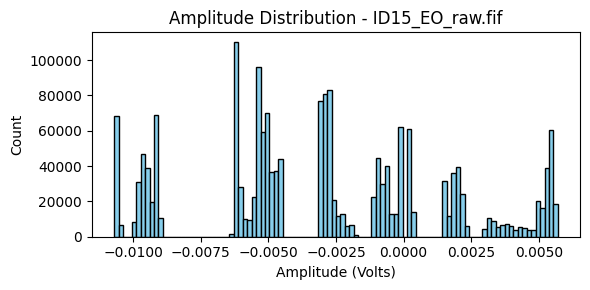


=== File: Segments\ID15_EO_raw.fif ===
Mean amplitude range: -1.06e-02 to 5.45e-03
RMS range: 1.63e-04 to 1.06e-02
Avg channel correlation: 0.126
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID16_EC_raw.fif


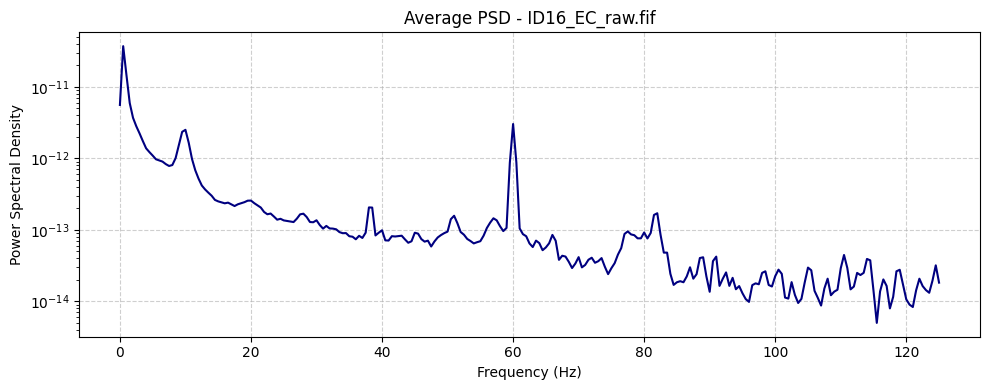

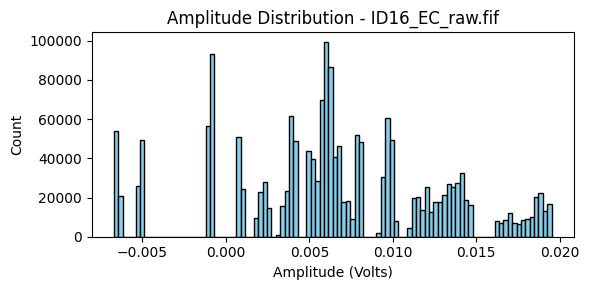


=== File: Segments\ID16_EC_raw.fif ===
Mean amplitude range: -6.54e-03 to 1.89e-02
RMS range: 8.39e-04 to 1.89e-02
Avg channel correlation: 0.617
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID16_EO_raw.fif


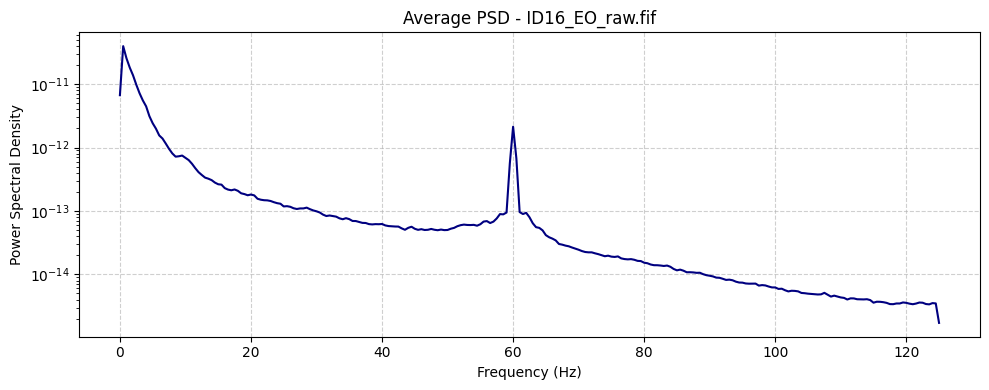

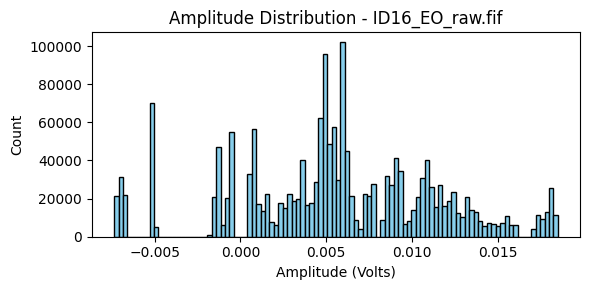


=== File: Segments\ID16_EO_raw.fif ===
Mean amplitude range: -6.99e-03 to 1.79e-02
RMS range: 6.04e-04 to 1.79e-02
Avg channel correlation: 0.705
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID18_EC_raw.fif


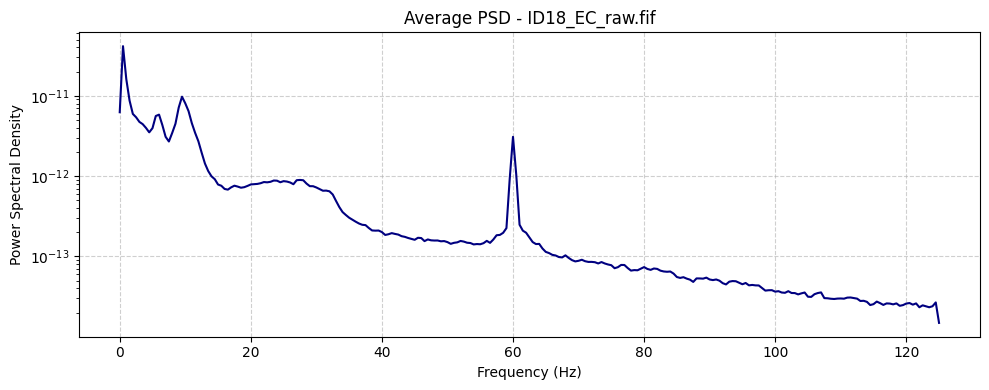

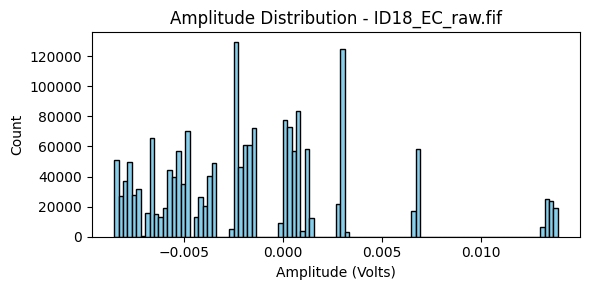


=== File: Segments\ID18_EC_raw.fif ===
Mean amplitude range: -8.34e-03 to 1.35e-02
RMS range: 2.08e-04 to 1.35e-02
Avg channel correlation: 0.114
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID18_EO_raw.fif


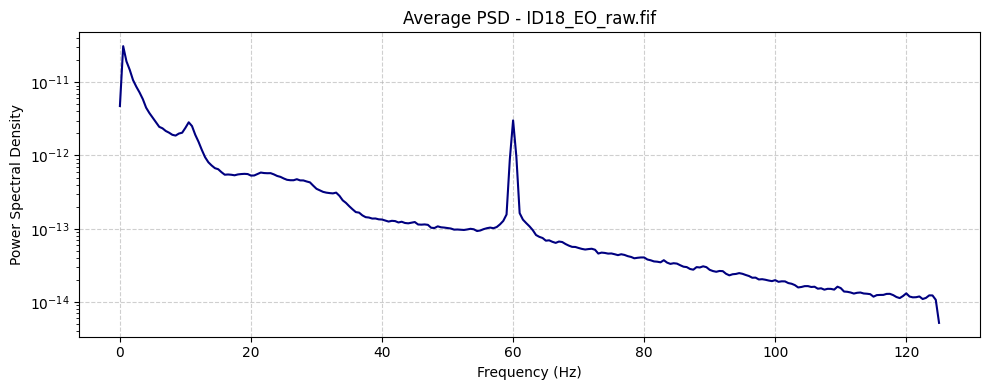

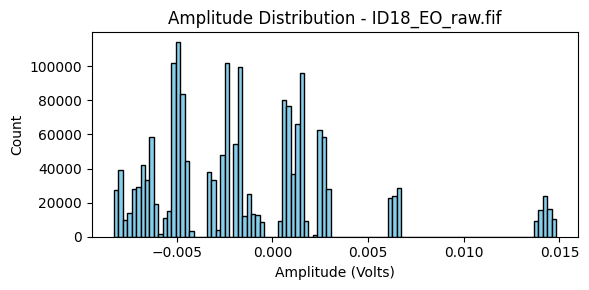


=== File: Segments\ID18_EO_raw.fif ===
Mean amplitude range: -7.99e-03 to 1.42e-02
RMS range: 6.96e-04 to 1.42e-02
Avg channel correlation: 0.114
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID19_EC_raw.fif


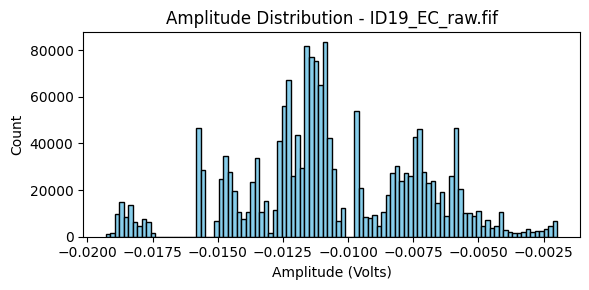


=== File: Segments\ID19_EC_raw.fif ===
Mean amplitude range: -1.84e-02 to -3.77e-03
RMS range: 3.91e-03 to 1.84e-02
Avg channel correlation: 0.437
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID19_EO_raw.fif


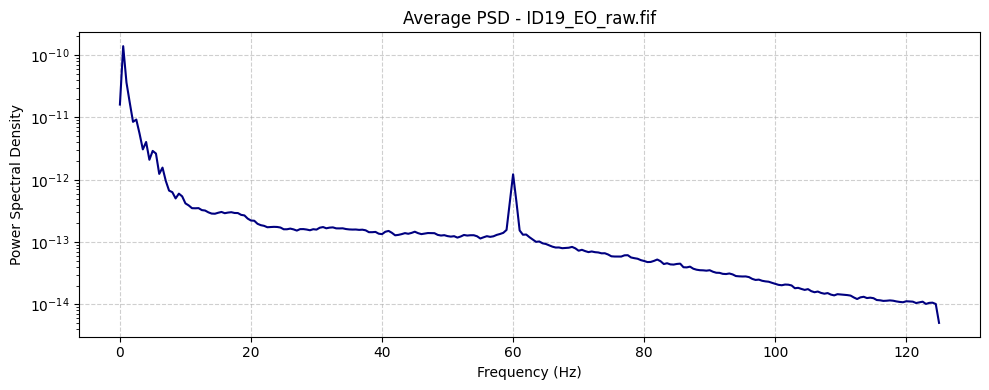

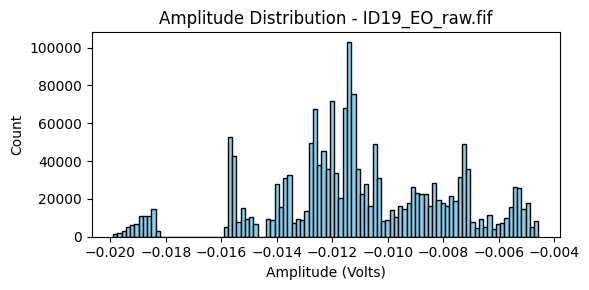


=== File: Segments\ID19_EO_raw.fif ===
Mean amplitude range: -1.89e-02 to -5.18e-03
RMS range: 5.19e-03 to 1.89e-02
Avg channel correlation: 0.217
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID1_EC_raw.fif


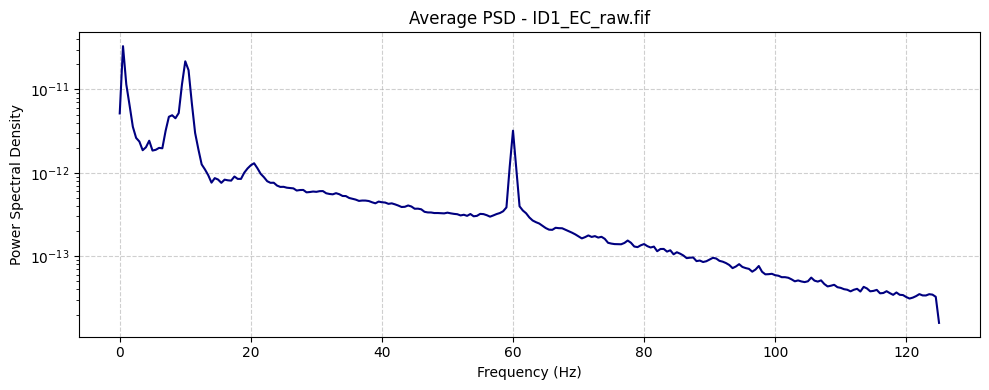

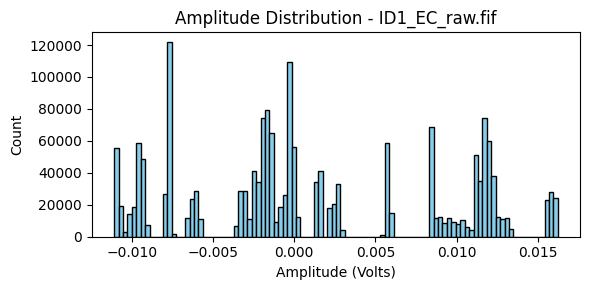


=== File: Segments\ID1_EC_raw.fif ===
Mean amplitude range: -1.09e-02 to 1.58e-02
RMS range: 1.53e-04 to 1.58e-02
Avg channel correlation: 0.081
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID1_EO_raw.fif


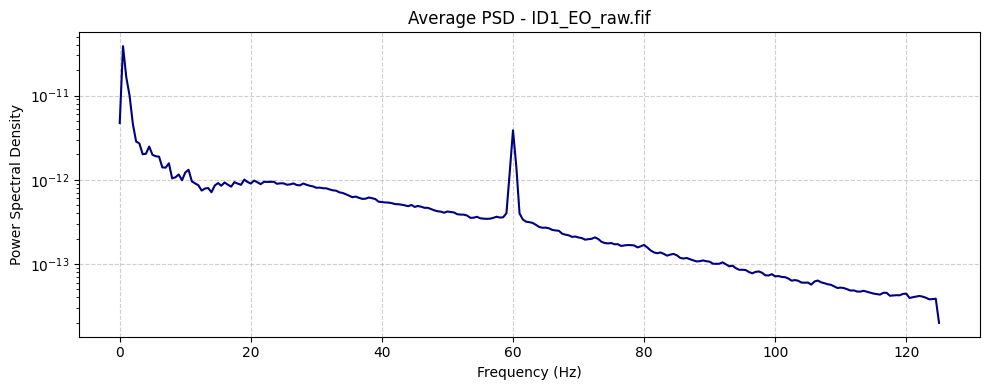

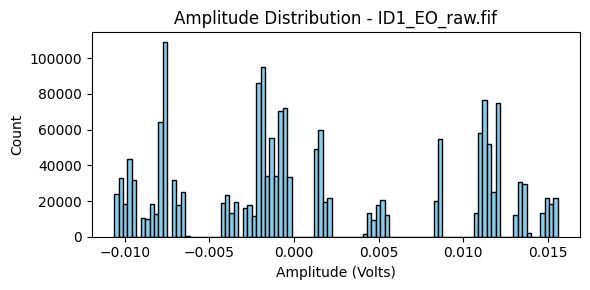


=== File: Segments\ID1_EO_raw.fif ===
Mean amplitude range: -1.03e-02 to 1.51e-02
RMS range: 4.90e-04 to 1.51e-02
Avg channel correlation: 0.158
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID20_EC_raw.fif


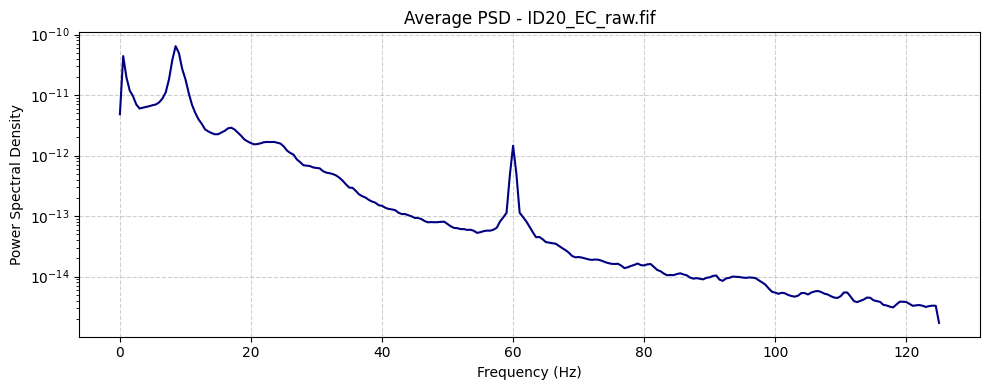

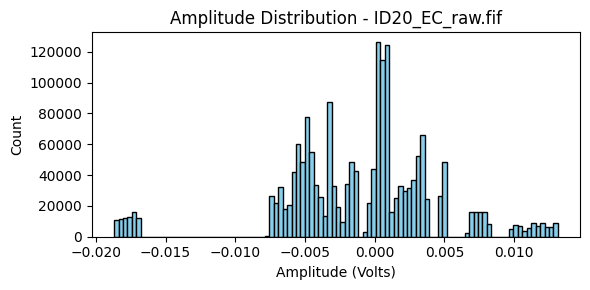


=== File: Segments\ID20_EC_raw.fif ===
Mean amplitude range: -1.77e-02 to 1.15e-02
RMS range: 1.79e-04 to 1.77e-02
Avg channel correlation: 0.733
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID20_EO_raw.fif


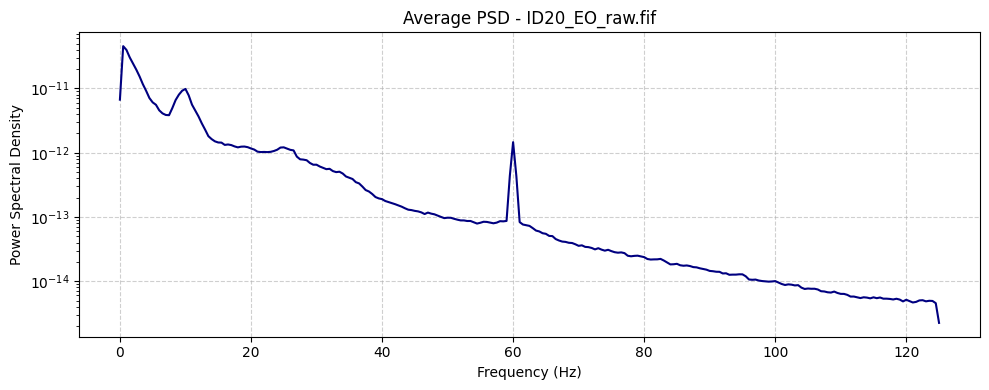

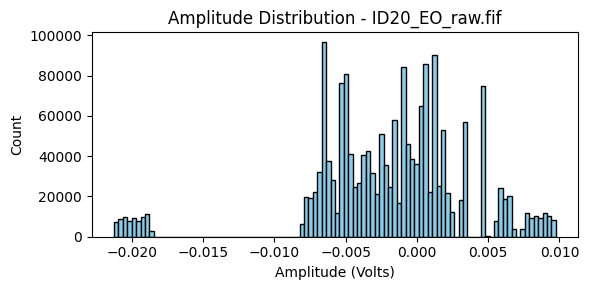


=== File: Segments\ID20_EO_raw.fif ===
Mean amplitude range: -1.99e-02 to 8.57e-03
RMS range: 3.19e-04 to 1.99e-02
Avg channel correlation: 0.264
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID21_EC_raw.fif



=== File: Segments\ID21_EC_raw.fif ===
Mean amplitude range: -1.12e-02 to 4.24e-03
RMS range: 1.57e-03 to 1.12e-02
Avg channel correlation: 0.423
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID21_EO_raw.fif


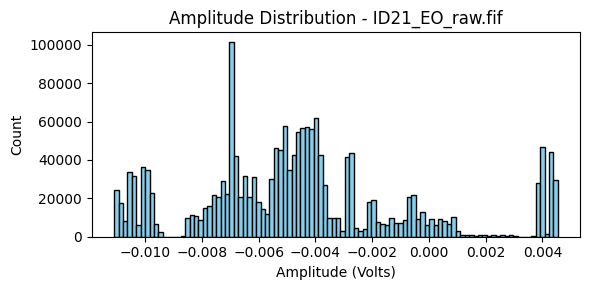


=== File: Segments\ID21_EO_raw.fif ===
Mean amplitude range: -1.08e-02 to 4.35e-03
RMS range: 5.56e-04 to 1.08e-02
Avg channel correlation: 0.682
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID22_EC_raw.fif



=== File: Segments\ID22_EC_raw.fif ===
Mean amplitude range: -2.36e-02 to -1.24e-03
RMS range: 1.25e-03 to 2.36e-02
Avg channel correlation: 0.094
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID22_EO_raw.fif


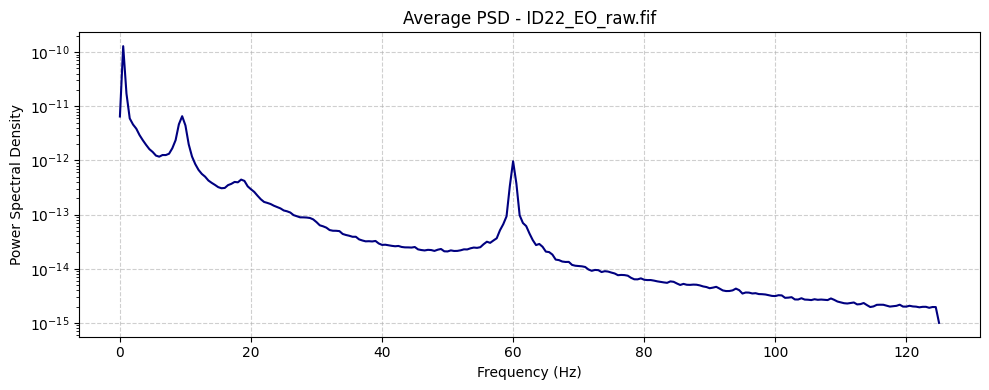

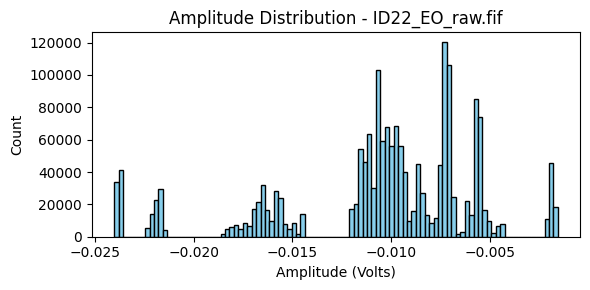


=== File: Segments\ID22_EO_raw.fif ===
Mean amplitude range: -2.38e-02 to -1.89e-03
RMS range: 1.90e-03 to 2.38e-02
Avg channel correlation: 0.086
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID23_EC_raw.fif


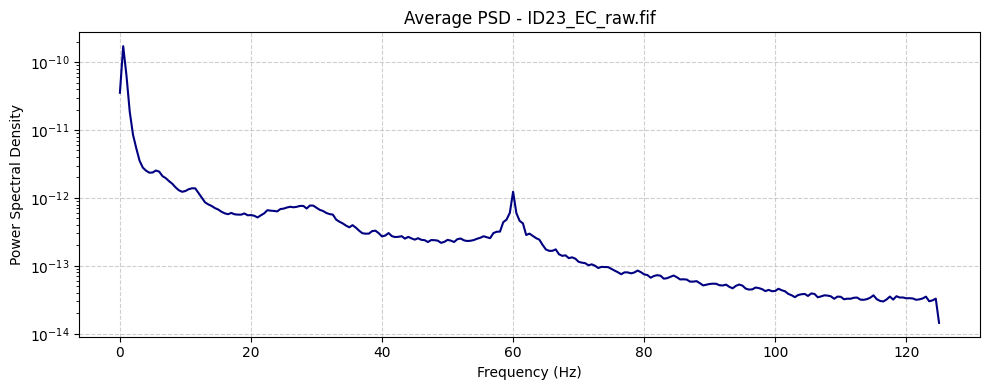


=== File: Segments\ID23_EC_raw.fif ===
Mean amplitude range: -3.36e-02 to -7.44e-03
RMS range: 7.44e-03 to 3.36e-02
Avg channel correlation: 0.224
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID23_EO_raw.fif



=== File: Segments\ID23_EO_raw.fif ===
Mean amplitude range: -3.33e-02 to -7.70e-03
RMS range: 7.70e-03 to 3.33e-02
Avg channel correlation: 0.144
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID24_EC_raw.fif



=== File: Segments\ID24_EC_raw.fif ===
Mean amplitude range: -1.19e-02 to 4.17e-03
RMS range: 6.17e-04 to 1.19e-02
Avg channel correlation: 0.545
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID24_EO_raw.fif


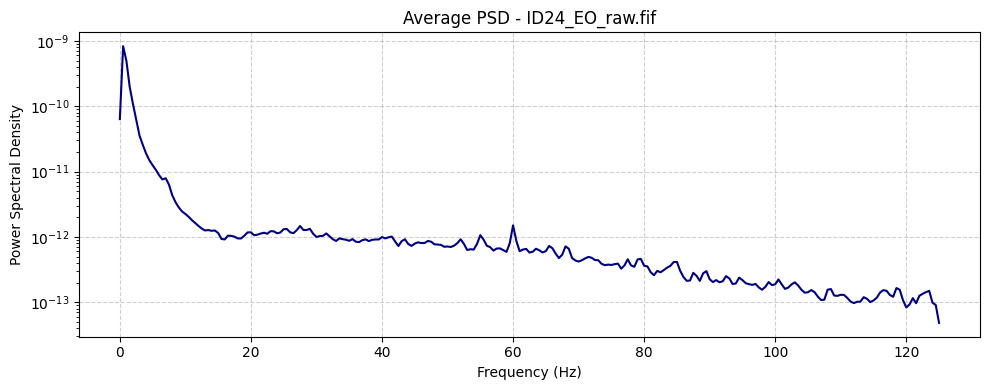

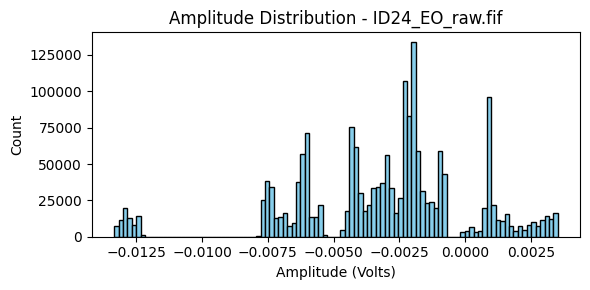


=== File: Segments\ID24_EO_raw.fif ===
Mean amplitude range: -1.28e-02 to 3.04e-03
RMS range: 8.65e-04 to 1.28e-02
Avg channel correlation: 0.463
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID25_EC_raw.fif


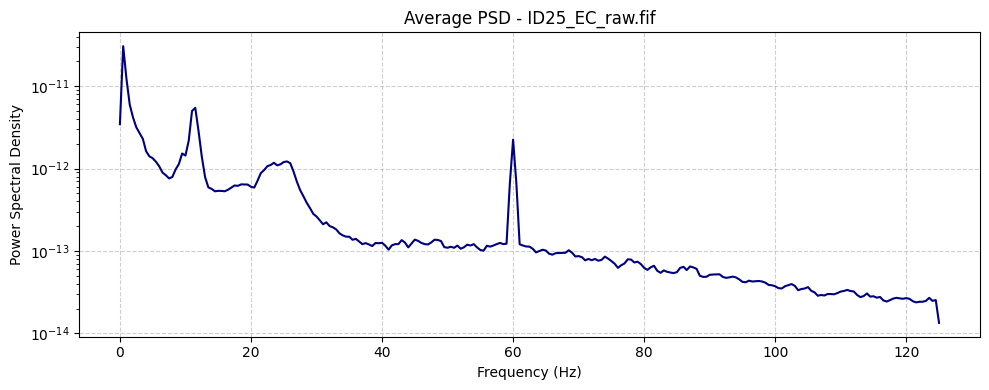


=== File: Segments\ID25_EC_raw.fif ===
Mean amplitude range: -1.09e-02 to 1.08e-02
RMS range: 1.32e-03 to 1.09e-02
Avg channel correlation: 0.179
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID25_EO_raw.fif


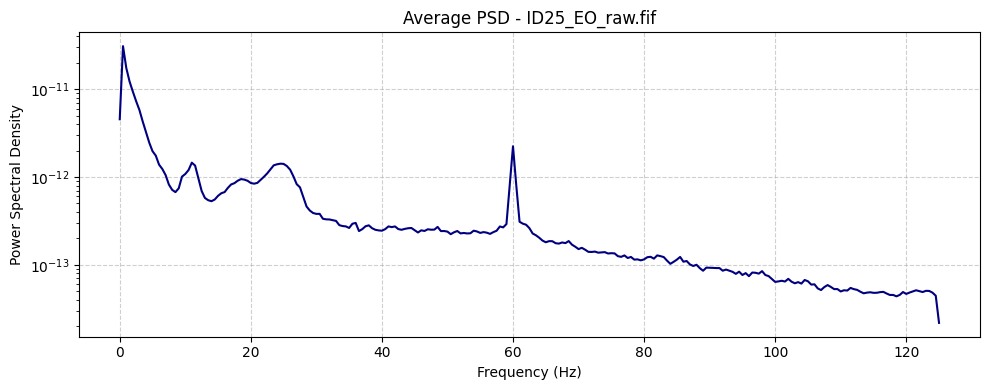

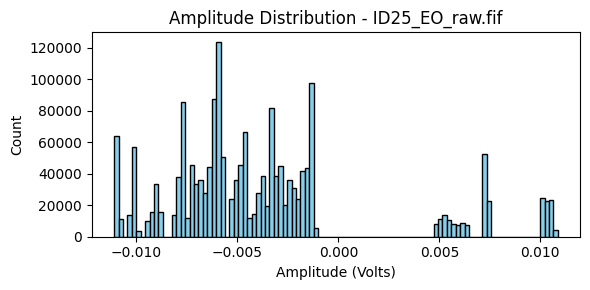


=== File: Segments\ID25_EO_raw.fif ===
Mean amplitude range: -1.09e-02 to 1.03e-02
RMS range: 1.31e-03 to 1.09e-02
Avg channel correlation: 0.143
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID26_EC_raw.fif


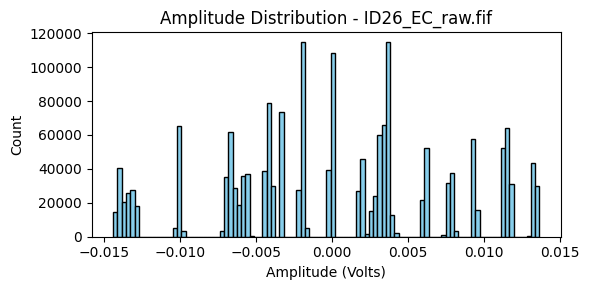


=== File: Segments\ID26_EC_raw.fif ===
Mean amplitude range: -1.40e-02 to 1.33e-02
RMS range: 8.71e-05 to 1.40e-02
Avg channel correlation: 0.567
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID26_EO_raw.fif


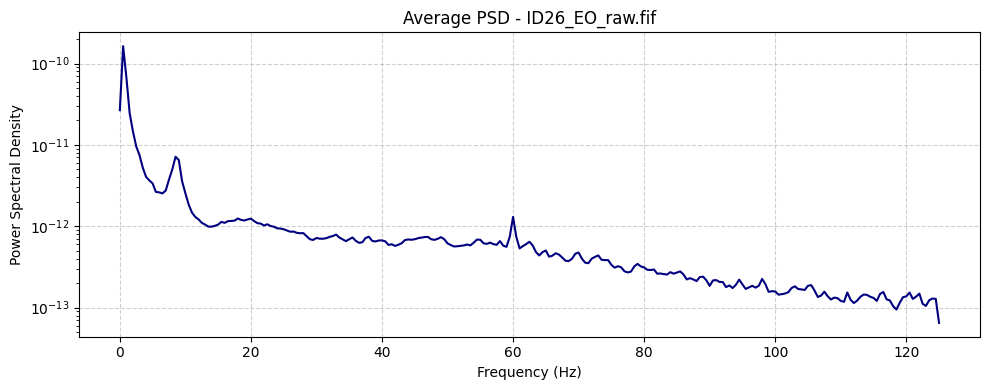


=== File: Segments\ID26_EO_raw.fif ===
Mean amplitude range: -1.46e-02 to 1.30e-02
RMS range: 1.97e-04 to 1.46e-02
Avg channel correlation: 0.572
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID27_EC_raw.fif


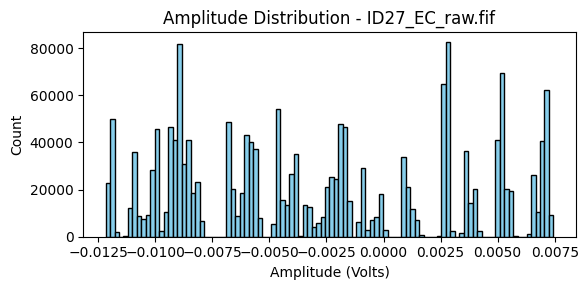


=== File: Segments\ID27_EC_raw.fif ===
Mean amplitude range: -1.19e-02 to 7.08e-03
RMS range: 6.80e-04 to 1.19e-02
Avg channel correlation: 0.150
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID27_EO_raw.fif


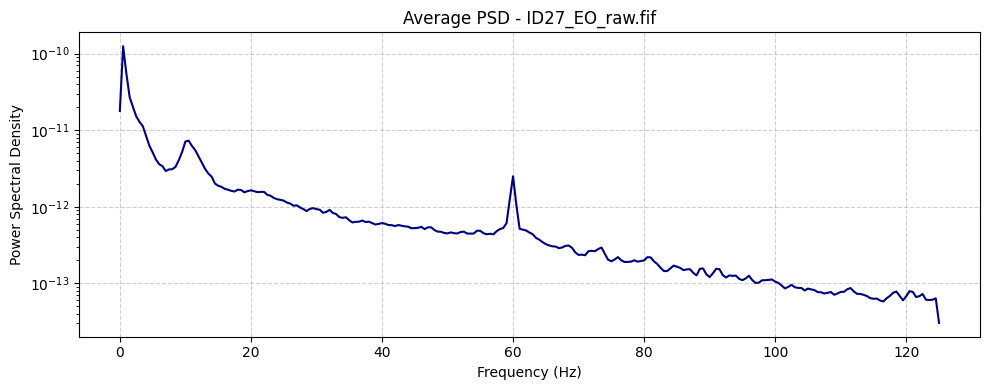


=== File: Segments\ID27_EO_raw.fif ===
Mean amplitude range: -1.20e-02 to 6.76e-03
RMS range: 8.16e-04 to 1.20e-02
Avg channel correlation: 0.101
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID2_EC_raw.fif


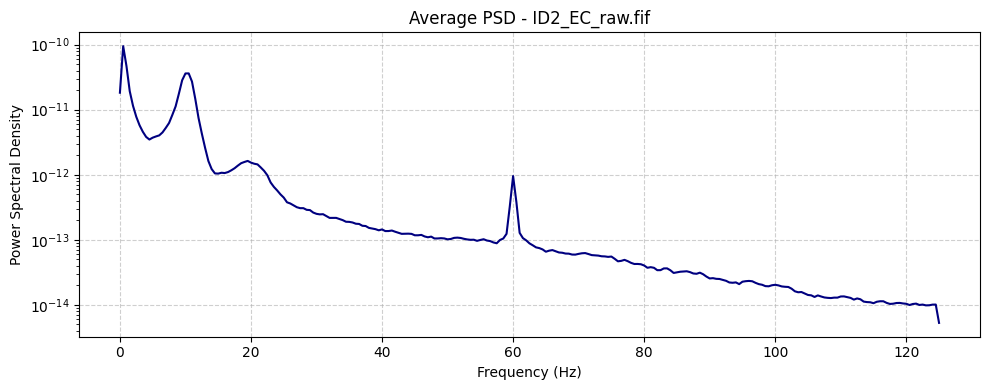

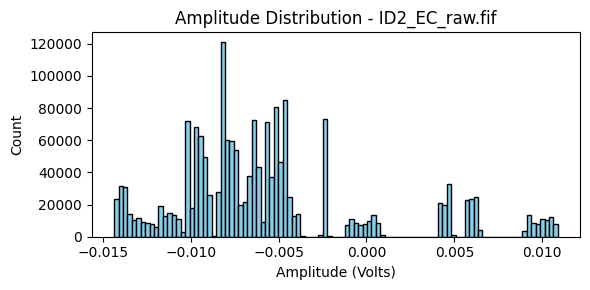


=== File: Segments\ID2_EC_raw.fif ===
Mean amplitude range: -1.39e-02 to 9.94e-03
RMS range: 6.11e-04 to 1.39e-02
Avg channel correlation: 0.678
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID2_EO_raw.fif


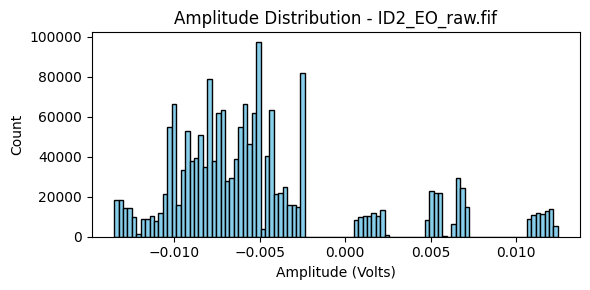


=== File: Segments\ID2_EO_raw.fif ===
Mean amplitude range: -1.29e-02 to 1.15e-02
RMS range: 1.58e-03 to 1.30e-02
Avg channel correlation: 0.937
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID30_EC_raw.fif


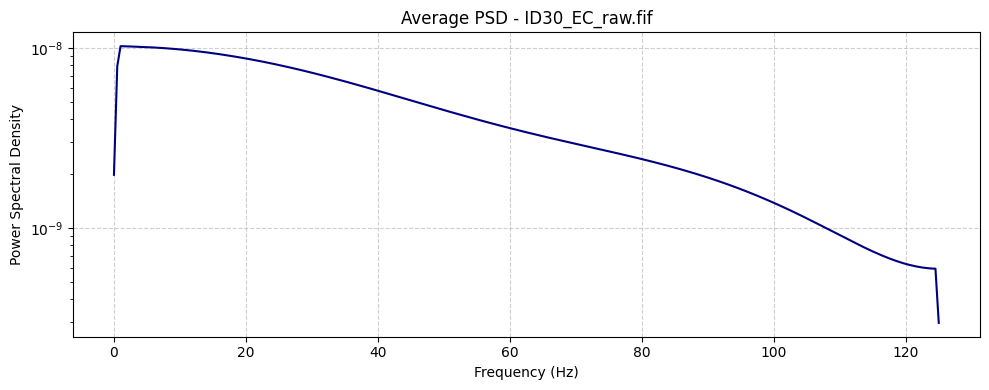


=== File: Segments\ID30_EC_raw.fif ===
Mean amplitude range: -1.57e-02 to 5.98e-03
RMS range: 8.21e-04 to 1.57e-02
Avg channel correlation: 0.194
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID30_EO_raw.fif


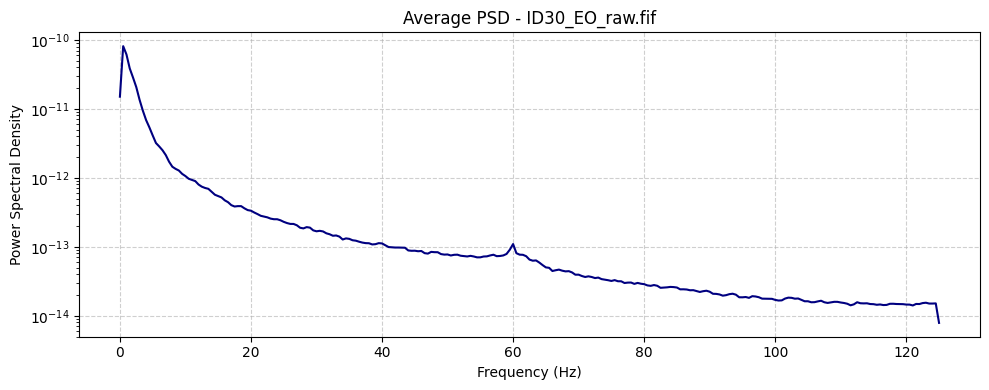


=== File: Segments\ID30_EO_raw.fif ===
Mean amplitude range: -1.65e-02 to 5.63e-03
RMS range: 6.87e-04 to 1.65e-02
Avg channel correlation: 0.215
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID31_EC_raw.fif


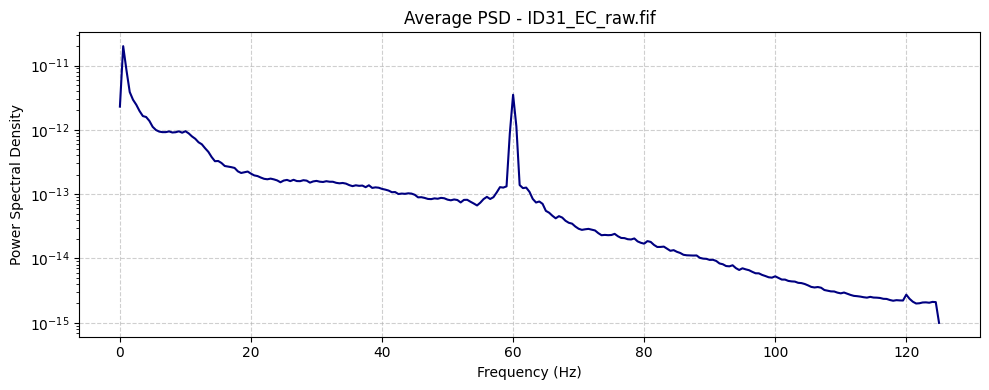

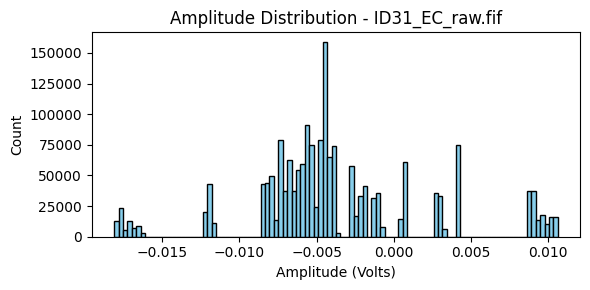


=== File: Segments\ID31_EC_raw.fif ===
Mean amplitude range: -1.73e-02 to 9.93e-03
RMS range: 5.94e-04 to 1.74e-02
Avg channel correlation: 0.144
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID31_EO_raw.fif


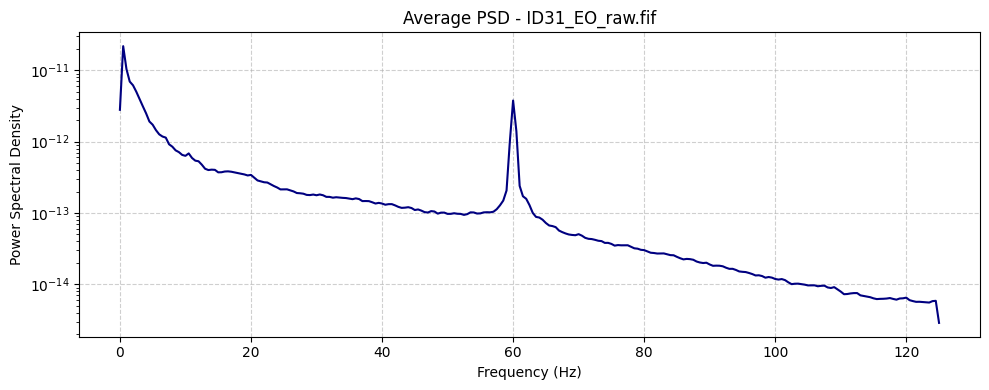

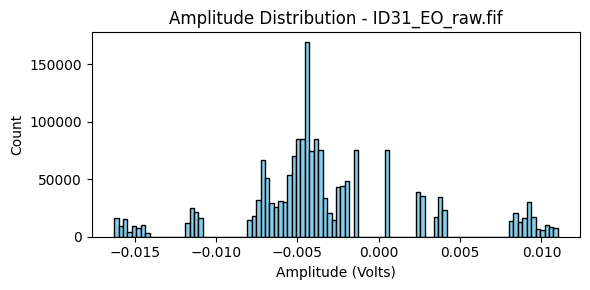


=== File: Segments\ID31_EO_raw.fif ===
Mean amplitude range: -1.54e-02 to 9.86e-03
RMS range: 5.25e-04 to 1.54e-02
Avg channel correlation: 0.351
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID33_EC_raw.fif


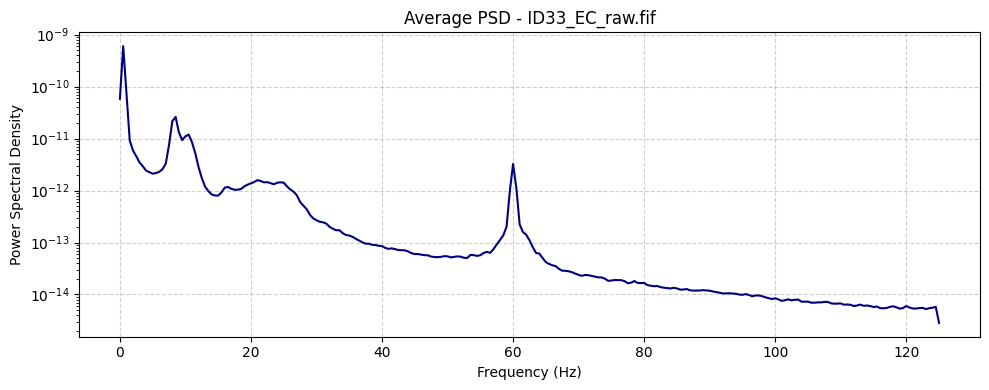


=== File: Segments\ID33_EC_raw.fif ===
Mean amplitude range: -8.50e-03 to 1.25e-02
RMS range: 2.39e-04 to 1.25e-02
Avg channel correlation: 0.527
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID33_EO_raw.fif


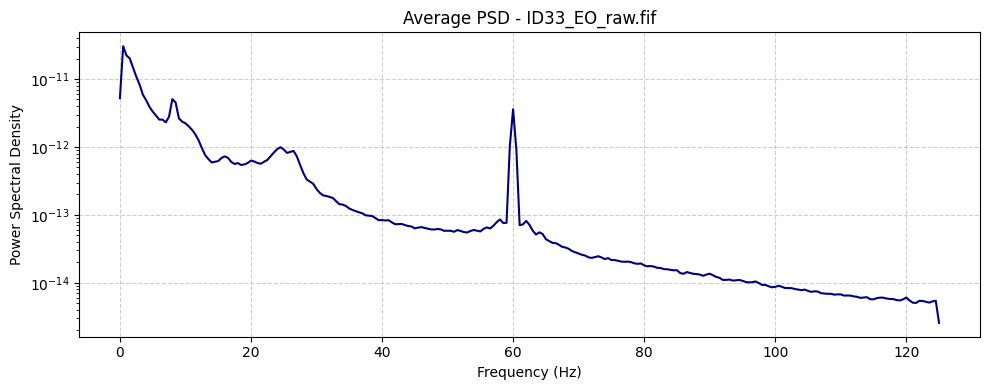


=== File: Segments\ID33_EO_raw.fif ===
Mean amplitude range: -7.71e-03 to 1.27e-02
RMS range: 1.64e-04 to 1.27e-02
Avg channel correlation: 0.091
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID35_EC_raw.fif


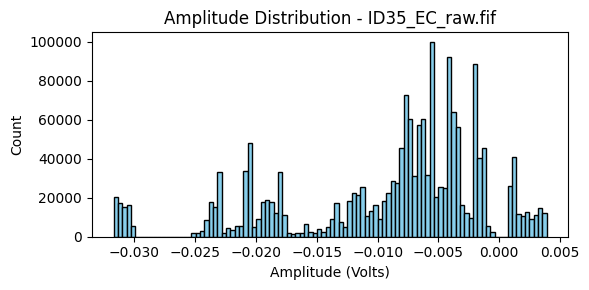


=== File: Segments\ID35_EC_raw.fif ===
Mean amplitude range: -3.10e-02 to 2.79e-03
RMS range: 1.15e-03 to 3.10e-02
Avg channel correlation: 0.196
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID35_EO_raw.fif


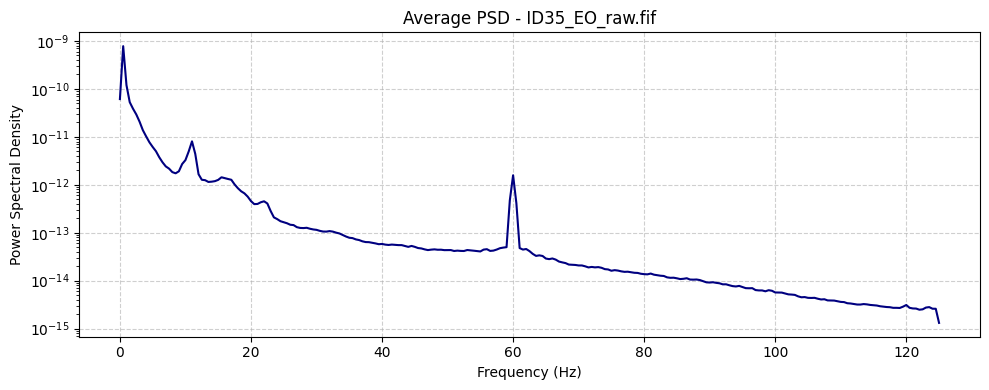

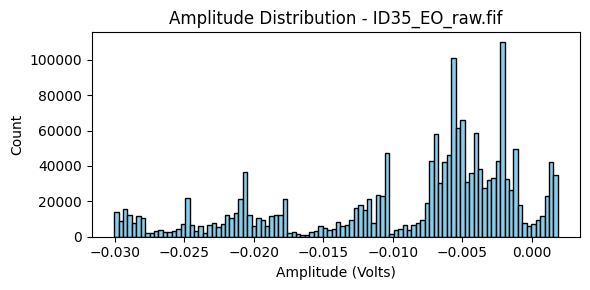


=== File: Segments\ID35_EO_raw.fif ===
Mean amplitude range: -2.90e-02 to 1.34e-03
RMS range: 1.04e-03 to 2.90e-02
Avg channel correlation: 0.305
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID37_EC_raw.fif


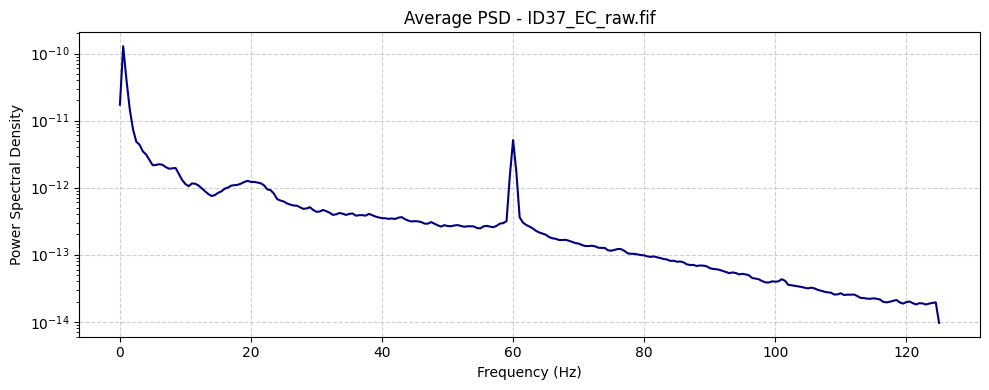

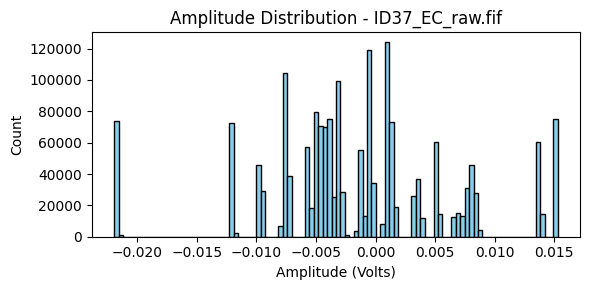


=== File: Segments\ID37_EC_raw.fif ===
Mean amplitude range: -2.18e-02 to 1.52e-02
RMS range: 3.86e-04 to 2.18e-02
Avg channel correlation: 0.295
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID37_EO_raw.fif


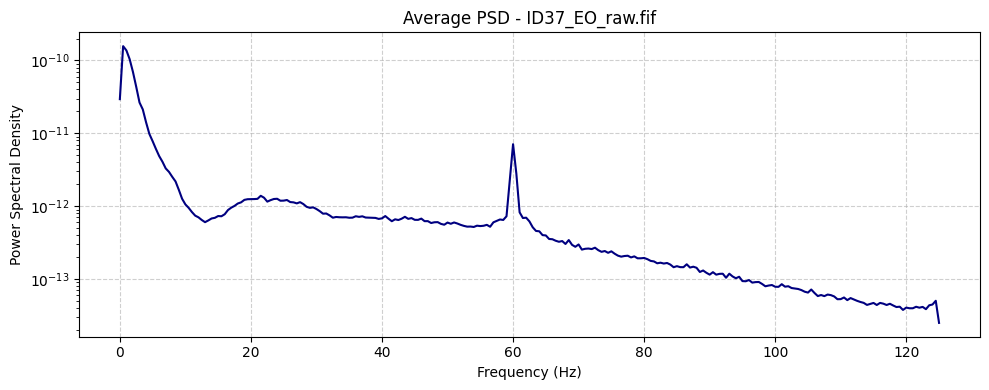

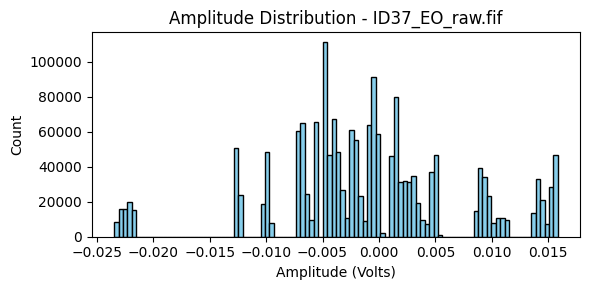


=== File: Segments\ID37_EO_raw.fif ===
Mean amplitude range: -2.24e-02 to 1.55e-02
RMS range: 1.72e-04 to 2.24e-02
Avg channel correlation: 0.132
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID38_EC_raw.fif


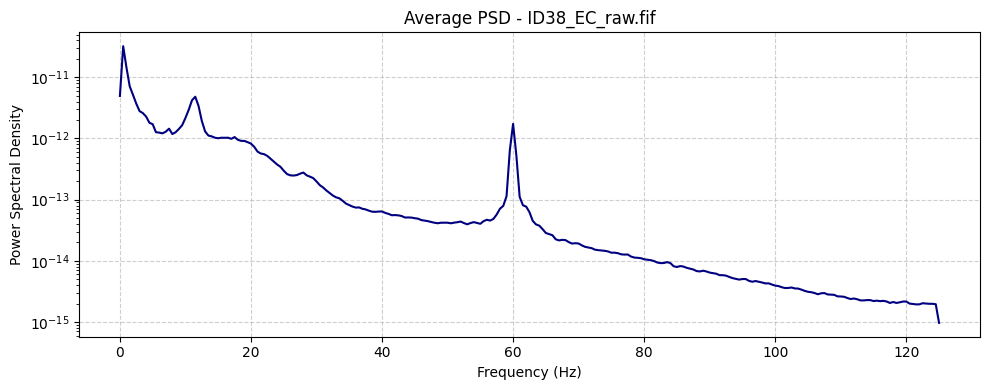

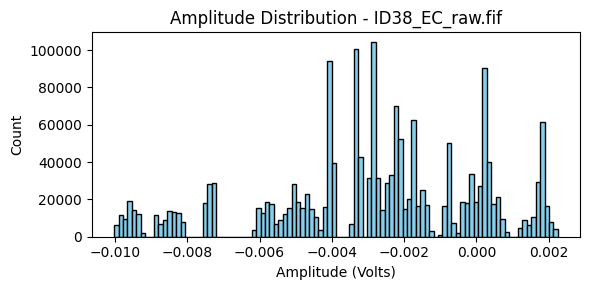


=== File: Segments\ID38_EC_raw.fif ===
Mean amplitude range: -9.60e-03 to 1.80e-03
RMS range: 2.19e-04 to 9.61e-03
Avg channel correlation: 0.314
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID38_EO_raw.fif



=== File: Segments\ID38_EO_raw.fif ===
Mean amplitude range: -8.99e-03 to 2.66e-03
RMS range: 6.56e-05 to 8.99e-03
Avg channel correlation: 0.216
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID39_EC_raw.fif


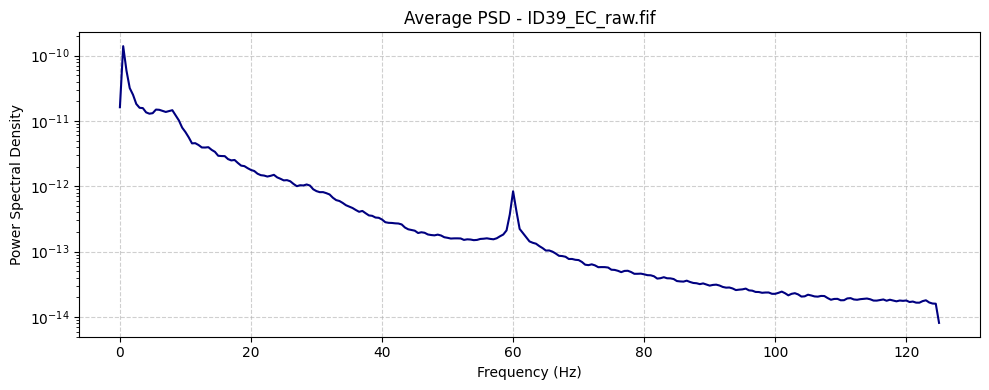

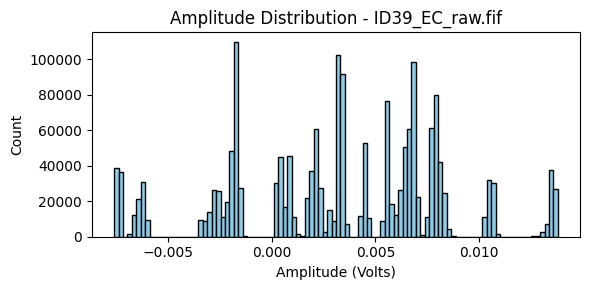


=== File: Segments\ID39_EC_raw.fif ===
Mean amplitude range: -7.39e-03 to 1.35e-02
RMS range: 3.35e-04 to 1.35e-02
Avg channel correlation: 0.056
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID39_EO_raw.fif


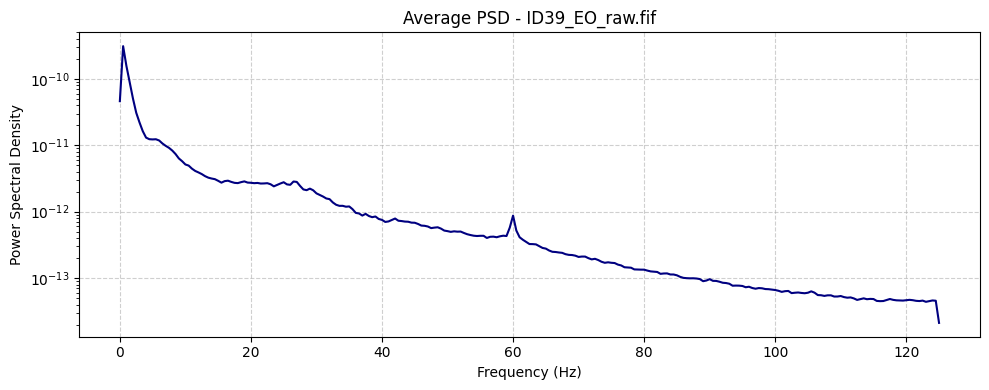

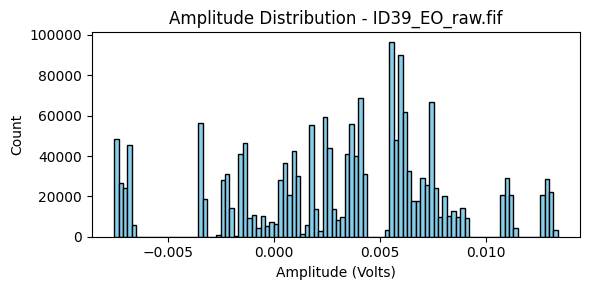


=== File: Segments\ID39_EO_raw.fif ===
Mean amplitude range: -7.33e-03 to 1.29e-02
RMS range: 5.46e-04 to 1.29e-02
Avg channel correlation: 0.026
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID3_EC_raw.fif


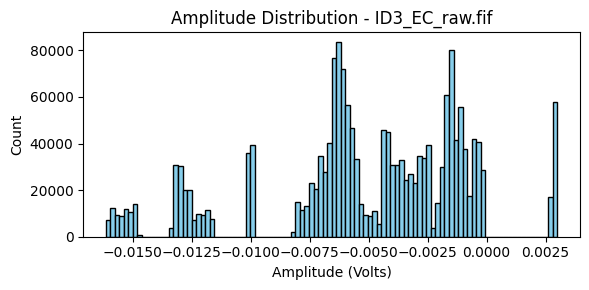


=== File: Segments\ID3_EC_raw.fif ===
Mean amplitude range: -1.54e-02 to 2.88e-03
RMS range: 4.40e-04 to 1.54e-02
Avg channel correlation: 0.793
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID3_EO_raw.fif


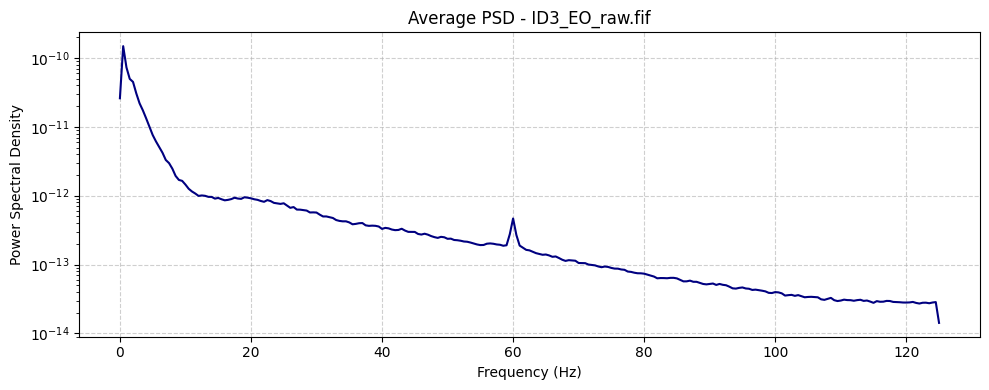


=== File: Segments\ID3_EO_raw.fif ===
Mean amplitude range: -1.66e-02 to 2.75e-03
RMS range: 1.05e-03 to 1.66e-02
Avg channel correlation: 0.453
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID40_EC_raw.fif


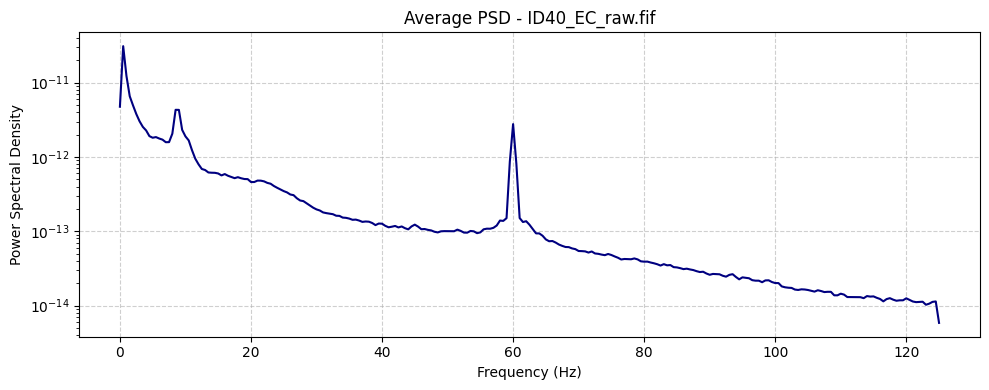


=== File: Segments\ID40_EC_raw.fif ===
Mean amplitude range: -7.50e-03 to 1.04e-02
RMS range: 8.01e-04 to 1.04e-02
Avg channel correlation: 0.247
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID40_EO_raw.fif


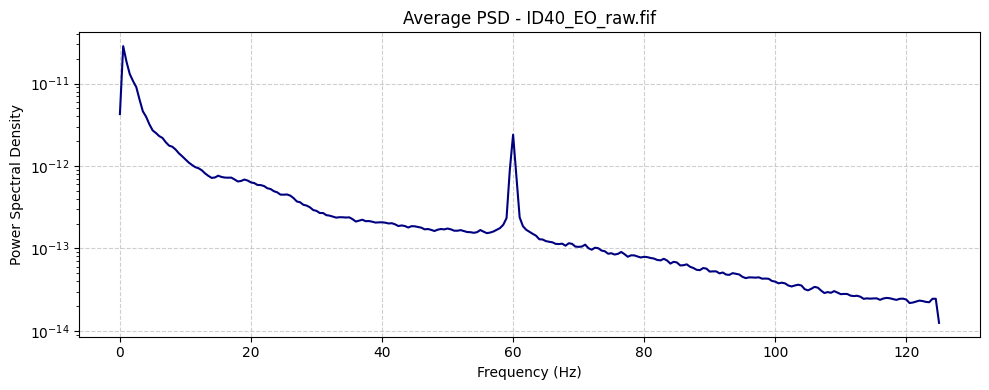

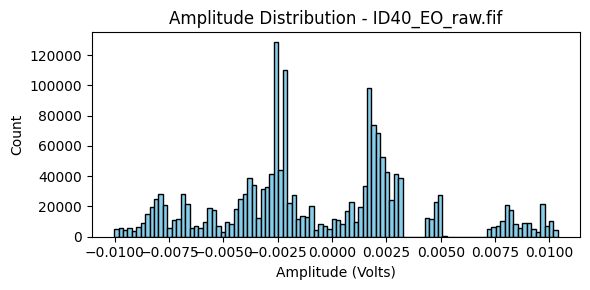


=== File: Segments\ID40_EO_raw.fif ===
Mean amplitude range: -8.78e-03 to 9.51e-03
RMS range: 5.20e-04 to 9.52e-03
Avg channel correlation: 0.758
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID41_EC_raw.fif


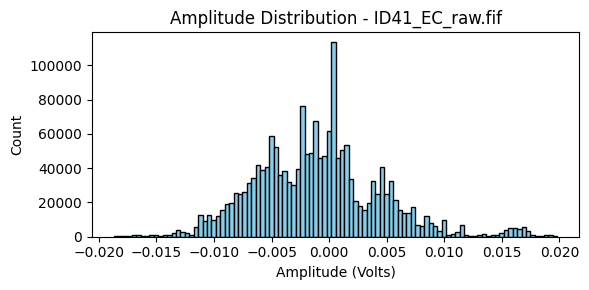


=== File: Segments\ID41_EC_raw.fif ===
Mean amplitude range: -7.75e-03 to 1.01e-02
RMS range: 3.81e-04 to 1.10e-02
Avg channel correlation: 0.553
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID41_EO_raw.fif


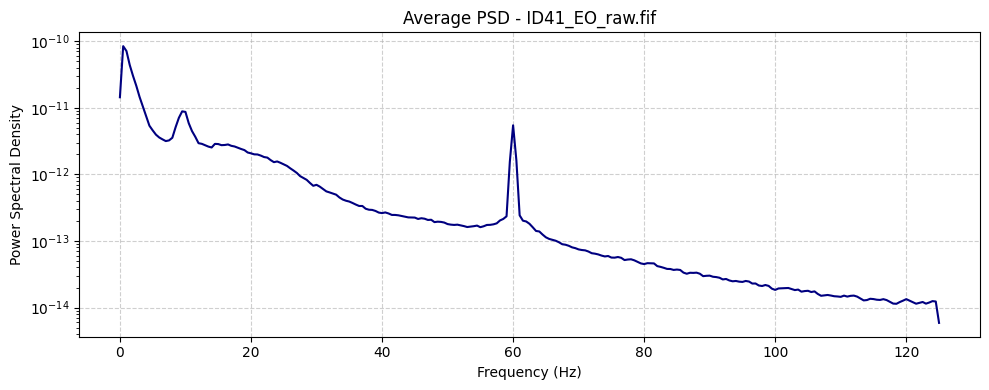

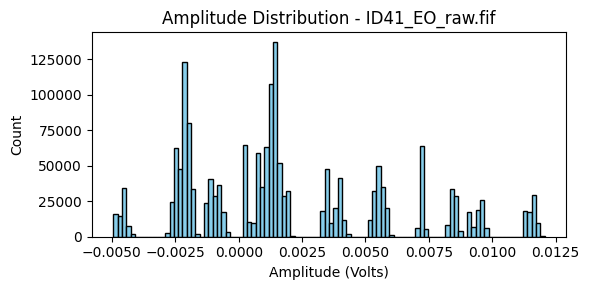


=== File: Segments\ID41_EO_raw.fif ===
Mean amplitude range: -4.60e-03 to 1.15e-02
RMS range: 2.85e-04 to 1.15e-02
Avg channel correlation: 0.147
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID43_EC_raw.fif


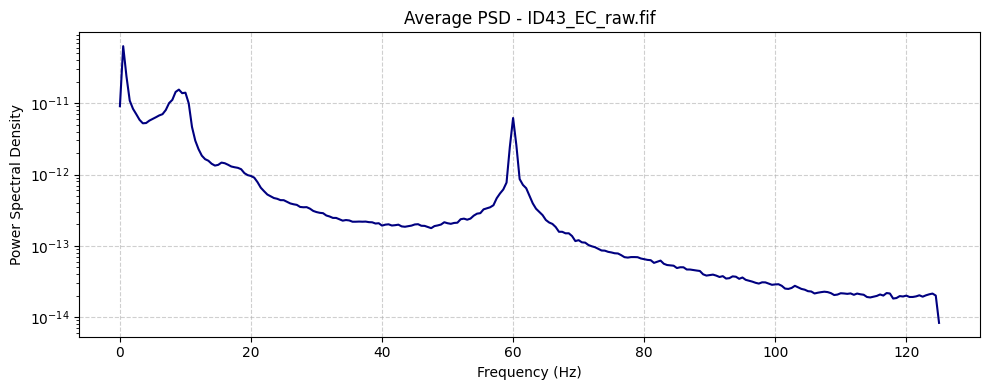

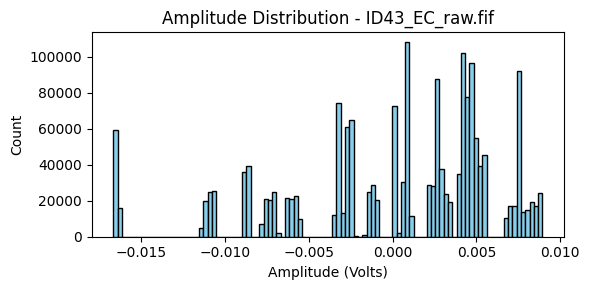


=== File: Segments\ID43_EC_raw.fif ===
Mean amplitude range: -1.65e-02 to 8.48e-03
RMS range: 1.66e-04 to 1.65e-02
Avg channel correlation: 0.020
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID43_EO_raw.fif


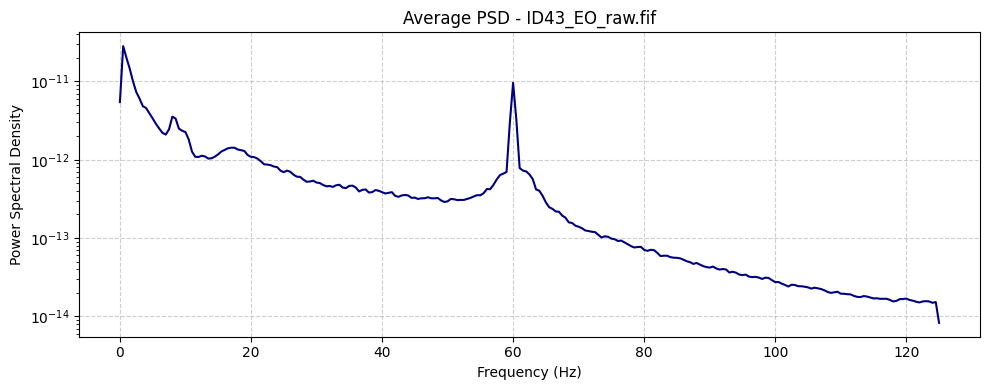

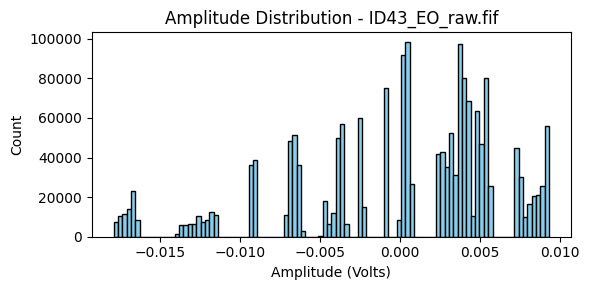


=== File: Segments\ID43_EO_raw.fif ===
Mean amplitude range: -1.70e-02 to 9.14e-03
RMS range: 2.90e-04 to 1.70e-02
Avg channel correlation: 0.012
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID4_EC_raw.fif


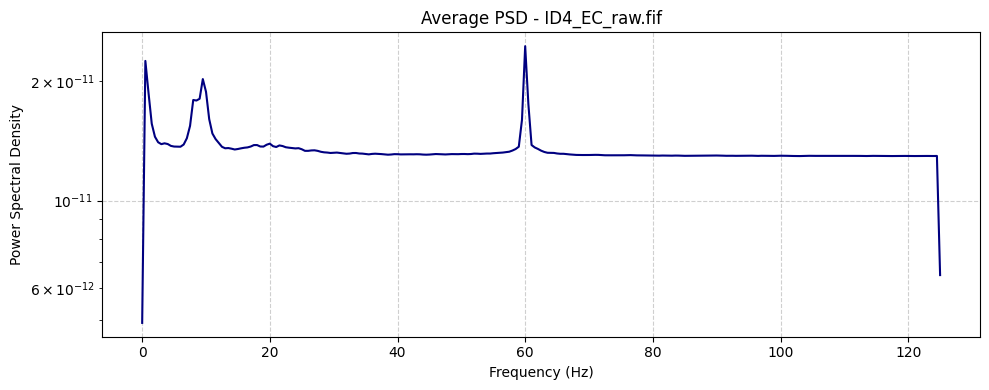

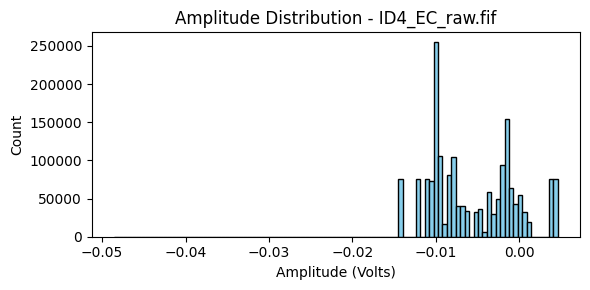


=== File: Segments\ID4_EC_raw.fif ===
Mean amplitude range: -1.42e-02 to 4.44e-03
RMS range: 1.88e-04 to 1.42e-02
Avg channel correlation: 0.087
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID4_EO_raw.fif


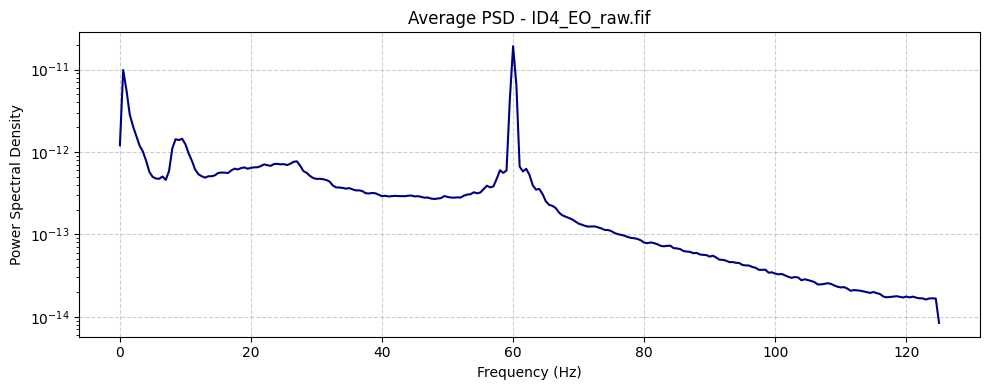

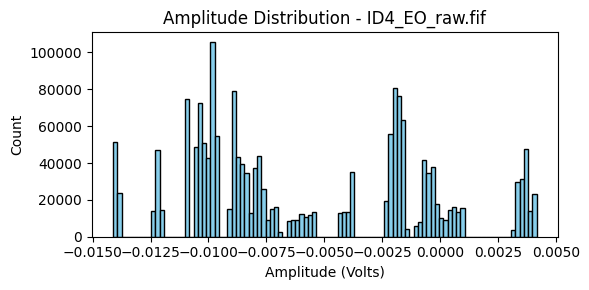


=== File: Segments\ID4_EO_raw.fif ===
Mean amplitude range: -1.40e-02 to 3.75e-03
RMS range: 5.65e-04 to 1.40e-02
Avg channel correlation: 0.322
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID5_EC_raw.fif


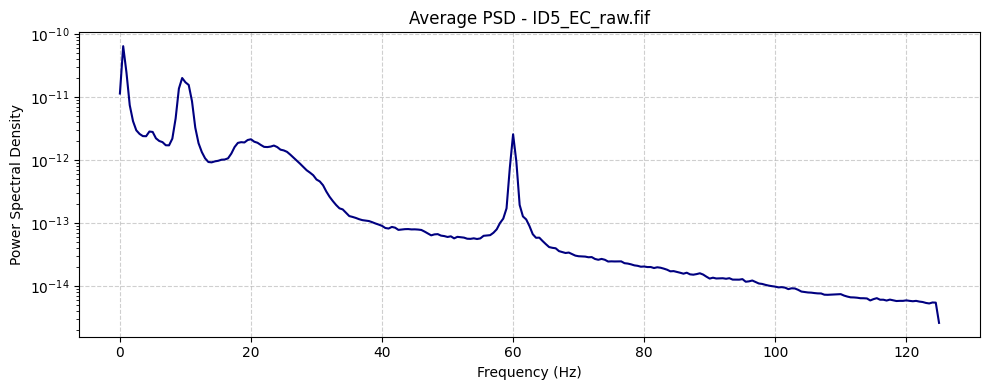

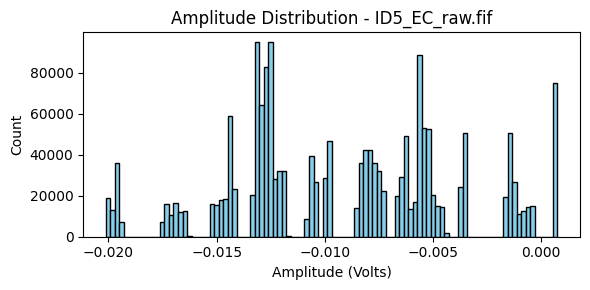


=== File: Segments\ID5_EC_raw.fif ===
Mean amplitude range: -1.97e-02 to 6.74e-04
RMS range: 6.75e-04 to 1.97e-02
Avg channel correlation: 0.587
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID5_EO_raw.fif


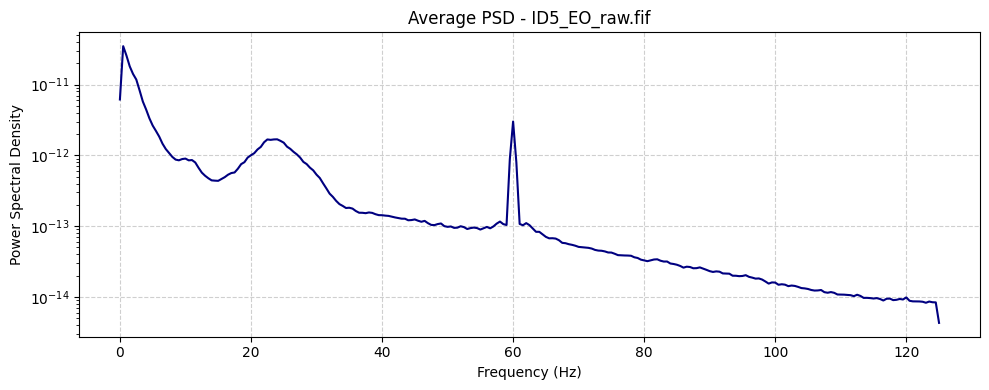

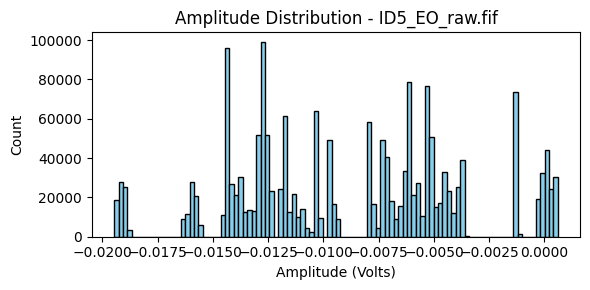


=== File: Segments\ID5_EO_raw.fif ===
Mean amplitude range: -1.91e-02 to 3.00e-04
RMS range: 1.80e-04 to 1.91e-02
Avg channel correlation: 0.194
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID6_EC_raw.fif


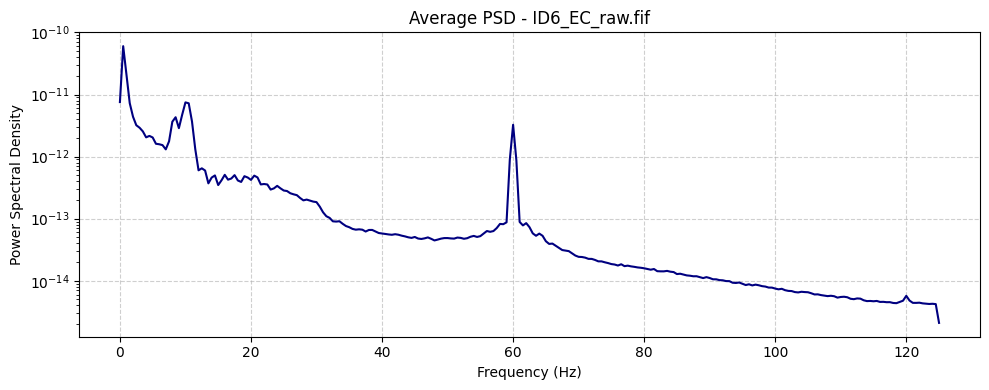

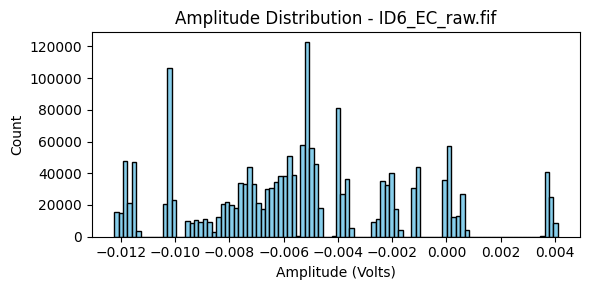


=== File: Segments\ID6_EC_raw.fif ===
Mean amplitude range: -1.19e-02 to 3.78e-03
RMS range: 6.46e-05 to 1.19e-02
Avg channel correlation: 0.094
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID6_EO_raw.fif


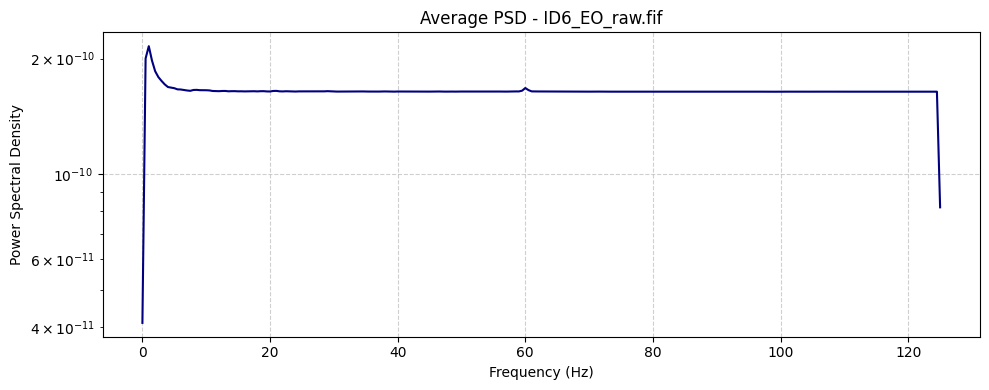

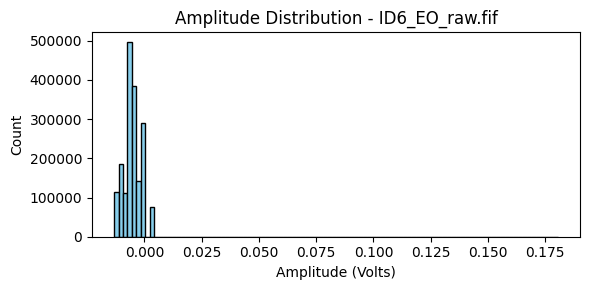


=== File: Segments\ID6_EO_raw.fif ===
Mean amplitude range: -1.26e-02 to 3.86e-03
RMS range: 2.31e-04 to 1.27e-02
Avg channel correlation: 0.017
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID7_EC_raw.fif


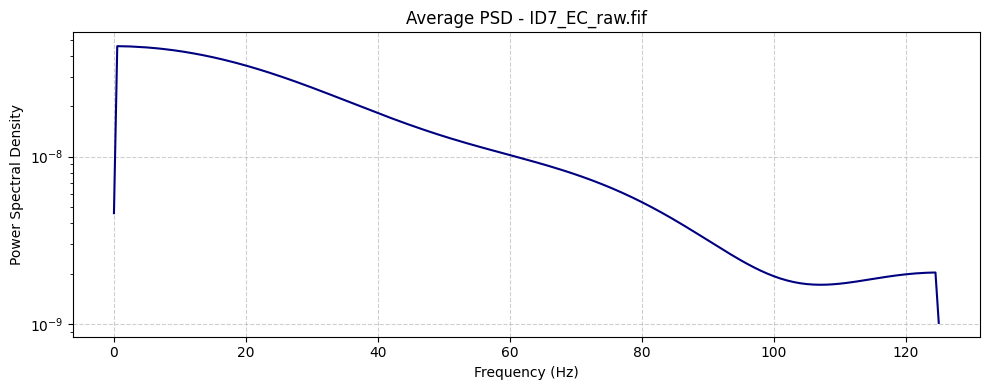

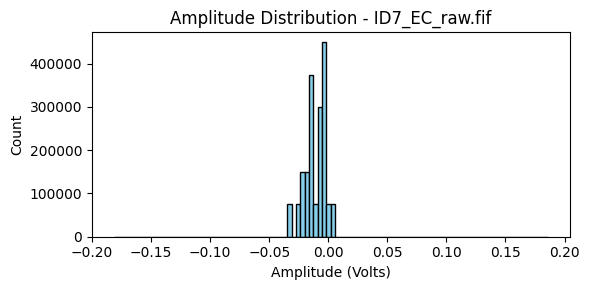


=== File: Segments\ID7_EC_raw.fif ===
Mean amplitude range: -3.14e-02 to 2.55e-03
RMS range: 2.03e-03 to 3.14e-02
Avg channel correlation: 0.009
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID7_EO_raw.fif


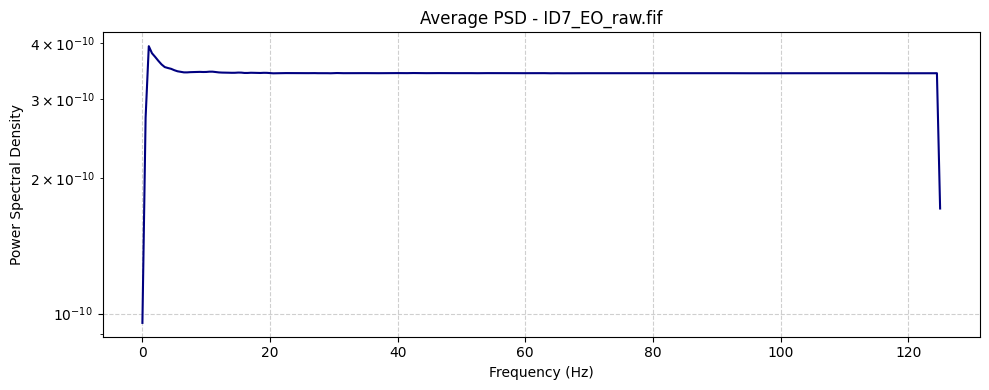

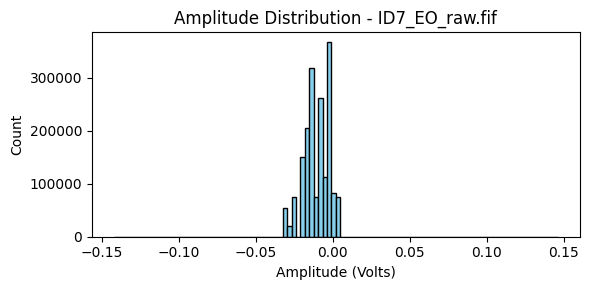


=== File: Segments\ID7_EO_raw.fif ===
Mean amplitude range: -3.01e-02 to 2.55e-03
RMS range: 1.09e-03 to 3.01e-02
Avg channel correlation: 0.323
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID8_EC_raw.fif


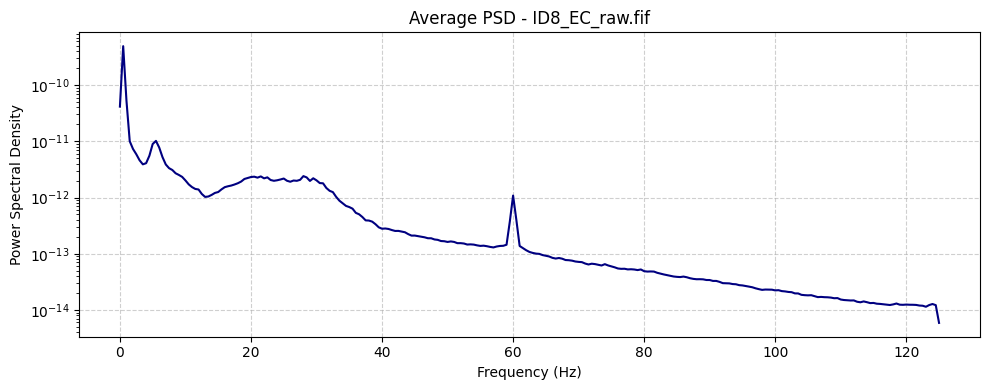

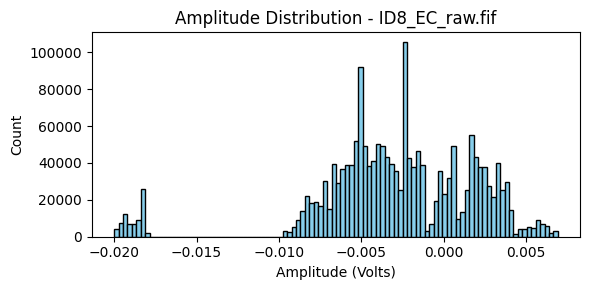


=== File: Segments\ID8_EC_raw.fif ===
Mean amplitude range: -1.88e-02 to 4.35e-03
RMS range: 4.50e-04 to 1.88e-02
Avg channel correlation: 0.830
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID8_EO_raw.fif


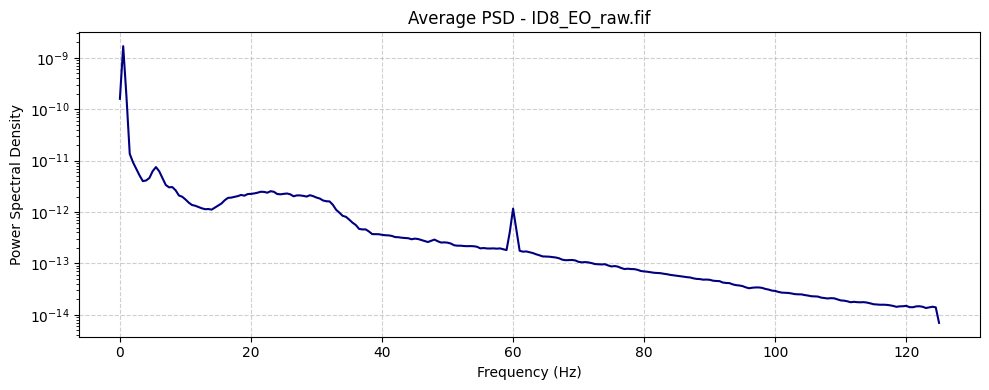

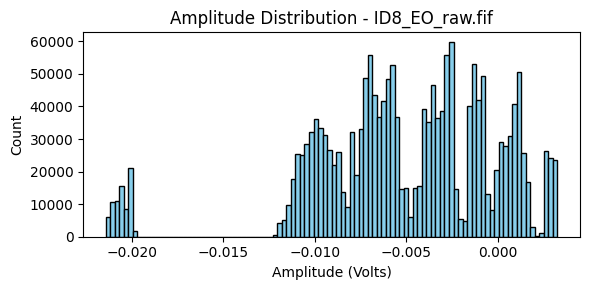


=== File: Segments\ID8_EO_raw.fif ===
Mean amplitude range: -2.05e-02 to 2.88e-03
RMS range: 6.52e-04 to 2.05e-02
Avg channel correlation: 0.839
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID9_EC_raw.fif


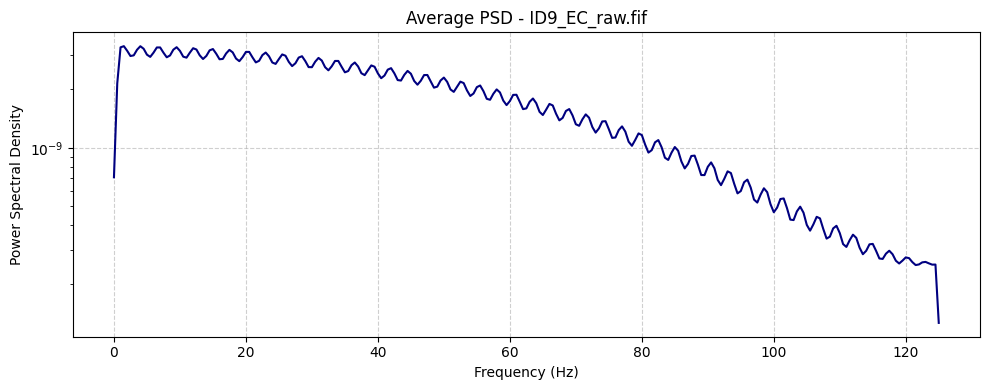

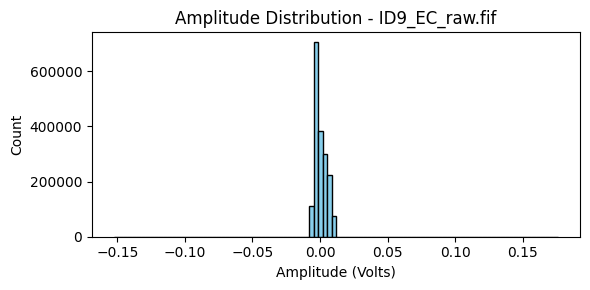


=== File: Segments\ID9_EC_raw.fif ===
Mean amplitude range: -5.30e-03 to 9.71e-03
RMS range: 3.14e-04 to 9.75e-03
Avg channel correlation: 0.143
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

📊 Checking: Segments\ID9_EO_raw.fif


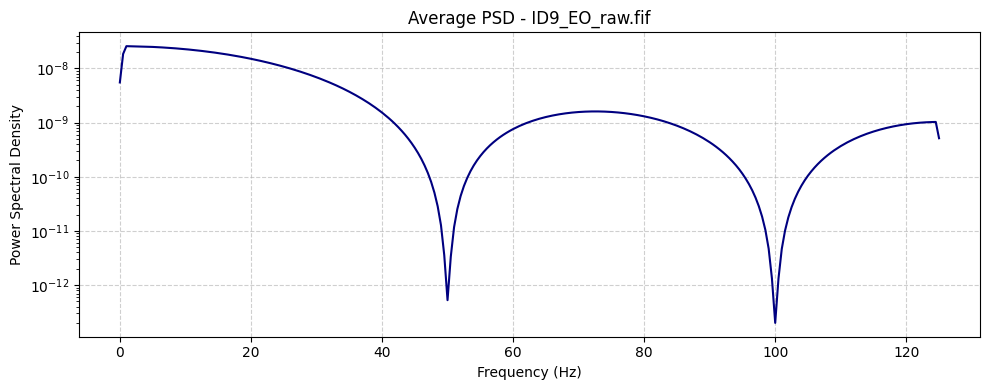

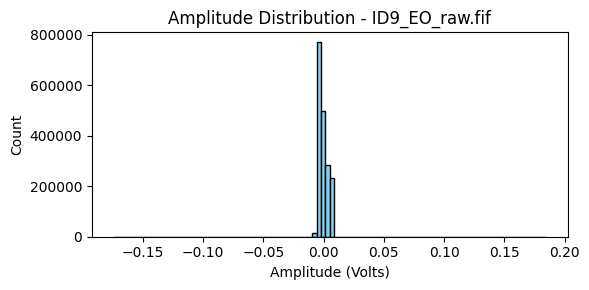


=== File: Segments\ID9_EO_raw.fif ===
Mean amplitude range: -4.94e-03 to 7.22e-03
RMS range: 1.18e-04 to 7.28e-03
Avg channel correlation: 0.285
⚠️  High RMS detected — possible noisy or saturated channels.
⚠️  Flat PSD — may indicate disconnected electrodes or flat data.

✅ Quality report saved → pain_dataset_quality_report.csv

              file  mean_abs  rms_mean   rms_max  avg_corr
0   ID0_EC_raw.fif  0.013468  0.013480  0.029130  0.686249
1   ID0_EO_raw.fif  0.014049  0.014052  0.029421  0.209254
2  ID10_EC_raw.fif  0.008670  0.008674  0.017370 -0.014267
3  ID10_EO_raw.fif  0.008425  0.008452  0.016835  0.122613
4  ID11_EC_raw.fif  0.004068  0.004078  0.010093  0.078081


In [10]:

# ---------------------------------------------------------------------------
# 🚀  Run quality check for all files
# ---------------------------------------------------------------------------
files = sorted(glob.glob(f"{DATA_PATH}/**/*.fif", recursive=True))
if not files:
    files = sorted(glob.glob(f"{DATA_PATH}/**/*.npy", recursive=True))

if not files:
    print("❌ No .fif or .npy files found in the given folder!")
else:
    results = []
    for f in files:
        print(f"\n📊 Checking: {f}")
        res = quality_check(f)
        results.append(res)

    df_quality = pd.DataFrame(results)
    df_quality.to_csv("pain_dataset_quality_report.csv", index=False)
    print("\n✅ Quality report saved → pain_dataset_quality_report.csv\n")
    print(df_quality.head())
